# **Graph-Policy-Induction Walkthrough**

This notebook goes through all of the code for the graph-based feature extraction step by step. This code has been modularised into various scripts and a config file where parameters can be adjusted according to the user (see README.md).

# Dependencies

Warning: Torch geometric can be hard to install so this particular package may take some time. It is best to install from conda-forge using mamba

### Standard Packages
- os
- json
- pathlib (Path)
- collections (defaultdict)
- dataclasses
- enum
- typing
- warnings

In [1]:
import json
import os
import warnings
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple
import time
import math

### External Packages (covered in requirements.txt):

- torch → covered by torch>=2.0.0,<2.3.0
    - torch.nn
    - torch.nn.functional (F)
- torch_geometric → covered by torch-geometric>=2.4.0
    - torch_geometric.data.HeteroData
    - torch_geometric.nn (SAGEConv, HeteroConv, Linear, GATConv)
- pandas → covered by pandas>=2.0.0
- numpy → covered by numpy>=1.24.0,<2.0.0
- sklearn → covered by scikit-learn>=1.3.0
    - sklearn.model_selection.train_test_split
    - sklearn.ensemble (RandomForestClassifier, GradientBoostingClassifier)
    - sklearn.metrics (precision_score, recall_score, roc_auc_score, fbeta_score)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import silhouette_score, precision_score, recall_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv, HeteroConv, Linear, SAGEConv
import seaborn as sns
import matplotlib.pyplot as plt


/home/imm/grte4643/miniconda3/envs/vela_clean/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configurations

In [3]:
warnings.filterwarnings('ignore')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Processing 


The data processing code loads and combines the private and public datasets from Vela. 

It parses various dtypes stored as json inside the csv columns, computes feature statistics, extracts baseline features for education/job and finally filters these features for redundnacy using jaccard similarity

### Combining Data

Checks for any duplicate founders (which there weren't any), adding a success tag and adding source tracking. 

In [4]:
def load_and_combine_datasets(
    public_path: str = '/home/imm/grte4643/Documents/Vela/Inputs/vcbench_final_public.csv',
    private_path: str = '/home/imm/grte4643/Documents/Vela/Inputs/vcbench_final_private.csv'
) -> pd.DataFrame:
    """
    Load and combine public + private datasets
    
    Returns:
        Combined DataFrame with 'source' column
    """
    
    df_public = pd.read_csv(public_path)
    df_private = pd.read_csv(private_path)
    
    print(f"Public:  {len(df_public)} founders ({df_public['success'].sum()} successful)")
    print(f"Private: {len(df_private)} founders ({df_private['success'].sum()} successful)")
    
    public_uuids = set(df_public['founder_uuid'])
    private_uuids = set(df_private['founder_uuid'])
    overlap = len(public_uuids & private_uuids)
    
    if overlap > 0:
        print(f"\n WARNING: {overlap} founders in both datasets - removing duplicates")
        df_private = df_private[~df_private['founder_uuid'].isin(public_uuids)]
    
    df_public['source'] = 'public'
    df_private['source'] = 'private'
    df_combined = pd.concat([df_public, df_private], ignore_index=True)
    
    print(f"\nCombined: {len(df_combined)} founders")
    print(f"  Success rate: {df_combined['success'].mean()*100:.2f}%")
    print(f"  Successful: {df_combined['success'].sum()}")
    print("=" * 50)
    
    return df_combined

df = load_and_combine_datasets()
print(df)

Public:  4500 founders (405 successful)
Private: 4500 founders (405 successful)

Combined: 9000 founders
  Success rate: 9.00%
  Successful: 810
                              founder_uuid  success  \
0     33159ebb-97ff-43fe-a80e-31fdcf467065        1   
1     33a7bba0-2ef6-415b-b73c-3dc994b8a86e        1   
2     0fe9fcdf-eb06-4e2c-88d8-04468b427298        1   
3     4f5620d4-9db8-4cfc-a1f5-2fd917472865        1   
4     c347a753-2280-48f8-9a78-8bcff30dd0ac        1   
...                                    ...      ...   
8995  4524d31b-af37-4980-9fe6-491b8d55eb88        0   
8996  4afdd8f1-b76d-4a7c-ab5d-e26eb5a9ed91        0   
8997  7d1dcfd0-4383-43f8-be23-660dc0c214e8        0   
8998  1844623e-c893-45a6-aa60-cc91b4a4bfb2        0   
8999  1ada8d2a-8875-483e-aad2-be7b6ef5c232        0   

                                               industry  \
0          Technology, Information & Internet Platforms   
1                             Entertainment & Live Arts   
2     Industrial 

### JSON Parsing Utility Functions

These are the JSON parsing helper functions. 
- Parse json converts JSON strings to Python dictionaries (used by feature extraction)
- Parse qs rank standardises mass unviersity ranking strings to clean integers
- Parse duration converts job duration strings to numeric years using midpoints

In [5]:
def parse_json_column(json_str: Any) -> List[Dict]:
    """Safely parse JSON columns."""
    if pd.isna(json_str):
        return []
    try:
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return []


def parse_qs_rank(qs_value: Any) -> int:
    """Parse QS ranking handling '200+', '101-150', etc."""
    if pd.isna(qs_value) or qs_value == '':
        return 999
    
    qs_str = str(qs_value).strip()
    
    if '+' in qs_str:
        try:
            return int(qs_str.replace('+', ''))
        except ValueError:
            return 999
    
    if '-' in qs_str:
        try:
            return int(qs_str.split('-')[0])
        except ValueError:
            return 999
    
    try:
        return int(float(qs_str))
    except ValueError:
        return 999


def parse_duration(duration_str: Any) -> float:
    """Parse job duration strings to years."""
    if pd.isna(duration_str) or duration_str == '':
        return 0.0
    
    d = str(duration_str).lower()
    
    if '10+' in d or '>10' in d:
        return 12.0
    elif '6-9' in d or '6-10' in d:
        return 7.5
    elif '4-5' in d or '4-6' in d:
        return 4.5
    elif '2-3' in d or '2-4' in d:
        return 2.5
    elif '<2' in d or '0-2' in d or '1-2' in d:
        return 1.0
    elif '<1' in d or '0-1' in d:
        return 0.5
    else:
        try:
            return float(''.join(c for c in d if c.isdigit() or c == '.'))
        except ValueError:
            return 0.0



### Education and Job Feature Extraction

For each founder, we turn the JSON data into numerical features accross job and education
- Education extraction parses the educations_json column and extracts or analyses: 
    - Degress and their number (PhD, MBA, Masters)
    - Fields (STEM, Business)
    - University Ranking (QS)

- Job extraction parses their jobs_json column and extracts or analyses: 
    - Seniority: CxO, VP, director role
    - Role types: tech, product, business
    - Company size: big vs startup
    - Experience: yrs worked in total

In [6]:
def extract_education_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract education-related features."""
    features = []
        
    for idx, row in df.iterrows():
        edu_data = parse_json_column(row.get('educations_json', '[]'))
        
        degrees = [e.get('degree', '') for e in edu_data if e.get('degree')]
        fields = [e.get('field', '') for e in edu_data if e.get('field')]
        qs_ranks = [parse_qs_rank(e.get('qs_ranking')) for e in edu_data]
        qs_ranks = [r for r in qs_ranks if r < 999]
        
        # degree analysis
        degree_score, has_phd, has_mba, has_masters = 0, 0, 0, 0
        for d in degrees:
            d_lower = d.lower()
            if 'phd' in d_lower or 'doctor' in d_lower:
                degree_score = max(degree_score, 4)
                has_phd = 1
            elif 'mba' in d_lower:
                degree_score = max(degree_score, 3)
                has_mba = 1
            elif 'master' in d_lower or 'msc' in d_lower:
                degree_score = max(degree_score, 2)
                has_masters = 1
        
        # field analysis
        stem_kw = ['computer', 'engineering', 'math', 'physics', 'science', 'data']
        business_kw = ['business', 'mba', 'economics', 'finance', 'management']
        is_stem = any(any(kw in f.lower() for kw in stem_kw) for f in fields)
        is_business = any(any(kw in f.lower() for kw in business_kw) for f in fields)
        
        # QS ranking
        best_qs = min(qs_ranks) if qs_ranks else 999
        
        features.append({
            'edu_num_degrees': len(degrees),
            'edu_highest_degree_score': degree_score,
            'edu_best_qs_rank': best_qs if best_qs < 999 else np.nan,
            'edu_is_top10_school': int(best_qs <= 10),
            'edu_is_top50_school': int(best_qs <= 50),
            'edu_is_top100_school': int(best_qs <= 100),
            'edu_has_phd': has_phd,
            'edu_has_mba': has_mba,
            'edu_has_masters': has_masters,
            'edu_has_advanced_degree': int(has_phd or has_mba or has_masters),
            'edu_is_stem': int(is_stem),
            'edu_is_business': int(is_business),
            'edu_is_stem_and_business': int(is_stem and is_business),
        })
    
    result = pd.DataFrame(features)
    return result


def extract_job_features(df: pd.DataFrame) -> pd.DataFrame:
    """Extract job-related features."""
    features = []
        
    for idx, row in df.iterrows():
        jobs_data = parse_json_column(row.get('jobs_json', '[]'))
        
        num_jobs = len(jobs_data)
        roles = [j.get('role', '') for j in jobs_data]
        industries = [j.get('industry', '') for j in jobs_data if j.get('industry')]
        durations = [j.get('duration', '') for j in jobs_data]
        company_sizes = [j.get('company_size', '') for j in jobs_data]
        
        # seniority
        num_cxo = sum(1 for r in roles if any(kw in r.lower() for kw in ['ceo', 'cto', 'cfo', 'chief']))
        num_founder = sum(1 for r in roles if any(kw in r.lower() for kw in ['founder', 'co-founder']))
        num_vp = sum(1 for r in roles if any(kw in r.lower() for kw in ['vp', 'vice president']))
        num_director = sum(1 for r in roles if any(kw in r.lower() for kw in ['director', 'head of']))
        total_senior = num_cxo + num_founder + num_vp + num_director
        
        # role types
        num_tech = sum(1 for r in roles if any(kw in r.lower() for kw in ['engineer', 'developer', 'scientist']))
        num_product = sum(1 for r in roles if any(kw in r.lower() for kw in ['product', 'pm', 'ux']))
        num_business = sum(1 for r in roles if any(kw in r.lower() for kw in ['sales', 'marketing', 'business']))
        
        # company size
        big_co_kw = ['5001', '10001', '10000+', '1001-5000']
        startup_kw = ['1-10', '11-50', '51-200']
        has_big_co = any(any(kw in str(cs) for kw in big_co_kw) for cs in company_sizes if cs)
        has_startup = any(any(kw in str(cs) for kw in startup_kw) for cs in company_sizes if cs)
        
        total_years = sum(parse_duration(d) for d in durations)
        unique_industries = len(set(industries))
        
        features.append({
            'job_num_prior_jobs': num_jobs,
            'job_num_senior_roles': total_senior,
            'job_num_cxo_roles': num_cxo,
            'job_num_founder_roles': num_founder,
            'job_num_tech_roles': num_tech,
            'job_num_product_roles': num_product,
            'job_num_business_roles': num_business,
            'job_total_experience_years': total_years,
            'job_num_industries': unique_industries,
            'job_has_cxo_experience': int(num_cxo > 0),
            'job_has_prior_founder_exp': int(num_founder > 0),
            'job_has_big_company_exp': int(has_big_co),
            'job_has_startup_exp': int(has_startup),
            'job_is_technical': int(num_tech > 0),
            'job_is_technical_senior': int(num_tech > 0 and total_senior > 0),
            'job_is_repeat_founder': int(num_founder >= 2),
            'job_big_company_then_startup': int(has_big_co and has_startup),
        })
    
    result = pd.DataFrame(features)
    return result

edu_features = extract_education_features(df)
job_features = extract_job_features(df)
X_baseline = pd.concat([edu_features, job_features], axis=1)

print(X_baseline)

      edu_num_degrees  edu_highest_degree_score  edu_best_qs_rank  \
0                   1                         0               1.0   
1                   0                         0               6.0   
2                   0                         0               NaN   
3                   2                         4               6.0   
4                   1                         0               4.0   
...               ...                       ...               ...   
8995                1                         0             163.0   
8996                1                         0             200.0   
8997                4                         4              48.0   
8998                3                         4               3.0   
8999                1                         0             200.0   

      edu_is_top10_school  edu_is_top50_school  edu_is_top100_school  \
0                       1                    1                     1   
1                       1  

### Removing Redundant Features 

This code is essentially feature quality analysis 
- Feature stats measure how useful a feature is for predicting a success
    - Precision: of founders with this feature, how many are successful in %?
    - Coverage: what % of founders have that feature?
    - Lift: how much better than random base rate is this feature - precision/overall success? 
- Jaccard similarity measures how similar too binary features are
    - this is intersection/union
    - if two features are almost identical, one is redundant 
- Removal removes duplicates to reduce noise
    - Ranks features by lift, keeps high-lift and removes too similar features
    - Reduces overfitting, speeds up training and makes model more interpritable

In [7]:
def compute_feature_stats(y: np.ndarray, feature_values: np.ndarray, 
                          threshold: Optional[float] = None) -> Dict:
    """Compute precision, coverage, and lift for a feature."""
    base_rate = y.mean()
    
    if threshold is not None:
        applies = feature_values > threshold
    else:
        applies = feature_values.astype(bool)
    
    coverage = np.mean(applies)
    n_applies = np.sum(applies)
    
    if n_applies > 0:
        precision = y[applies].mean()
        lift = precision / base_rate if base_rate > 0 else 0
    else:
        precision = 0.0
        lift = 0.0
    
    return {
        "precision": precision,
        "coverage": coverage,
        "lift": lift,
        "n_applies": int(n_applies),
        "n_success_applies": int(y[applies].sum()) if n_applies > 0 else 0,
        "base_rate": base_rate
    }

def compute_jaccard_similarity(f1: np.ndarray, f2: np.ndarray) -> float:
    """Compute Jaccard similarity between two binary feature vectors."""
    f1_bool = f1.astype(bool)
    f2_bool = f2.astype(bool)
    intersection = np.sum(f1_bool & f2_bool)
    union = np.sum(f1_bool | f2_bool)
    return intersection / union if union > 0 else 0.0

def remove_redundant_features(X: pd.DataFrame, y: pd.Series, 
                              threshold: float = 0.8) -> Tuple[pd.DataFrame, List]:
    """Remove features with Jaccard > threshold."""
    lifts = {}
    for col in X.columns:
        stats = compute_feature_stats(y.values, X[col].fillna(0).values)
        lifts[col] = stats['lift']
    
    sorted_cols = sorted(X.columns, key=lambda c: lifts[c], reverse=True)
    
    kept_features = []
    removed_features = []
    
    for col in sorted_cols:
        is_redundant = False
        for kept in kept_features:
            sim = compute_jaccard_similarity(
                X[col].fillna(0).values,
                X[kept].fillna(0).values
            )
            if sim > threshold:
                is_redundant = True
                removed_features.append((col, kept, sim))
                break
        
        if not is_redundant:
            kept_features.append(col)
    
    print(f"change: {len(X.columns)} -> {len(kept_features)} features")
    return X[kept_features], removed_features

y = df['success']
X_baseline_clean, removed_log = remove_redundant_features(X_baseline, y, threshold=0.6)

print(removed_log)

change: 30 -> 17 features
[('edu_is_top100_school', 'edu_is_top50_school', 0.8078024337866857), ('job_num_tech_roles', 'job_is_technical_senior', 0.6573485811096993), ('job_is_technical', 'job_is_technical_senior', 0.6573485811096993), ('edu_has_advanced_degree', 'edu_highest_degree_score', 1.0), ('job_has_big_company_exp', 'job_big_company_then_startup', 0.6117021276595744), ('job_has_startup_exp', 'job_big_company_then_startup', 0.6467162080739104), ('job_has_prior_founder_exp', 'job_num_founder_roles', 1.0), ('job_num_cxo_roles', 'job_num_senior_roles', 0.7674528301886793), ('job_has_cxo_experience', 'job_num_senior_roles', 0.7674528301886793), ('job_num_industries', 'job_num_senior_roles', 0.6741714285714285), ('edu_best_qs_rank', 'job_num_senior_roles', 0.63917288914417), ('job_total_experience_years', 'job_num_senior_roles', 0.6887627695800227), ('job_num_prior_jobs', 'job_num_senior_roles', 0.7080828323313293)]


### Saving key information

In [8]:
'''
output_dir = Path("./outputs/experiment/processed")

X_baseline_clean.to_csv(output_dir / 'baseline_features_COMBINED.csv', index=False)

pd.DataFrame({
    'founder_idx': range(len(y)),
    'success': y.values,
    'source': df['source'].values  
}).to_csv(output_dir / 'labels_COMBINED.csv', index=False)

founders_text = pd.DataFrame({
    'founder_idx': range(len(df)),
    'anonymised_prose': df['anonymised_prose'],
    'source': df['source']  
})
founders_text.to_csv(output_dir / 'founders_text_COMBINED.csv', index=False)

df.to_csv(Path("./data/raw") / 'vcbench_combined.csv', index=False)
'''

'\noutput_dir = Path("./outputs/experiment/processed")\n\nX_baseline_clean.to_csv(output_dir / \'baseline_features_COMBINED.csv\', index=False)\n\npd.DataFrame({\n    \'founder_idx\': range(len(y)),\n    \'success\': y.values,\n    \'source\': df[\'source\'].values  \n}).to_csv(output_dir / \'labels_COMBINED.csv\', index=False)\n\nfounders_text = pd.DataFrame({\n    \'founder_idx\': range(len(df)),\n    \'anonymised_prose\': df[\'anonymised_prose\'],\n    \'source\': df[\'source\']  \n})\nfounders_text.to_csv(output_dir / \'founders_text_COMBINED.csv\', index=False)\n\ndf.to_csv(Path("./data/raw") / \'vcbench_combined.csv\', index=False)\n'

# Metrics 



In traditional ML, we cant to classify everythign correctly so false positives and false negatives are equally as bad.

As a VC, Vela wants to find the BEST founders to invest in with limited capital and time. This is reflected in the metrics used throughout this notebook.

There are two imporant metrics: 
1. precision@k 
2. fBeta

### F Beta

Compute f beta is the foundaiton of the f0.5 score that is used by Vela. The idea is that, when you balance precision and recall preicsion is weighted more heavily when beta < 1.
- F1 score (beta = 1): Equal weight to precision and recall
- F0.5 score (beta = 0.5): Precision counts 2x more than recall
- F2 score (beta = 2): Recall counts counts 2x more than precision

Compute preicsion recall f05 computes precision / recall and builds a confusion matrix and calculates the f0.5
- TP: invest in founder who succeeded
- FP: invested in a founder who failed
- FN: passed on a founder who succeeded
- TN: passed on a founder who failed

Find optimal threshold f0.5 finds the optimal 'confidence threshold' to make investment decisions
- when you train a ML model it outputs a probability for each founder which have to be converted into binary deicsions
- threshold for probility is optimsed on VALIDATION DATA using validation labels
- this maintains a minimum of 10% recall as want to catch some founders
- the threshold maximises f0.5 (precision weighted)
- this function tests 80 differnt thresholds and picks one based on the val data


Problem with threshold-based:
1. It is not natural for a VC to say 'invest above 65%'
2. It is not flexible as there is a fixed threshold
3. It is less generalisable to new data
4. It does not preserve order and loses the relative ranking
5. It overfits to validation
6. 'Precision at 0.65' is far less interpritable than '37% hit rate in top 100'

In [9]:
def compute_f_beta(precision: float, recall: float, beta: float = 0.5) -> float:
    """
    Compute F-beta score.
    
    F0.5 weights precision MORE than recall (Vela's preferred metric).
    From GPTree paper: "we prioritize precision over recall"
    """
    if precision + recall == 0:
        return 0.0
    beta_sq = beta ** 2
    return (1 + beta_sq) * precision * recall / (beta_sq * precision + recall)

def compute_precision_recall_f05(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Compute precision, recall, and F0.5 score."""
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f05 = compute_f_beta(precision, recall, beta=0.5)
    
    return {'precision': precision, 'recall': recall, 'f05': f05,
            'tp': int(tp), 'fp': int(fp), 'fn': int(fn)}

def find_optimal_threshold_f05(y_true: np.ndarray, y_proba: np.ndarray,
                                min_recall: float = 0.10) -> dict:
    """
    Find threshold that maximizes F0.5 while maintaining minimum recall.
    
    vela : maintain recall at at least 10% and maximise precision
    """
    best_f05 = 0
    best_threshold = 0.5
    best_metrics = None
    
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_proba >= threshold).astype(int)
        metrics = compute_precision_recall_f05(y_true, y_pred)
        
        if metrics['recall'] >= min_recall and metrics['f05'] > best_f05:
            best_f05 = metrics['f05']
            best_threshold = threshold
            best_metrics = metrics
    
    if best_metrics is None:
        y_pred = (y_proba >= 0.5).astype(int)
        best_metrics = compute_precision_recall_f05(y_true, y_pred)
        best_threshold = 0.5
    
    best_metrics['threshold'] = best_threshold
    return best_metrics



### Precision at K

Compute precision at k is the most important metric and this:
1. Ranks all foundres by their predicted success probability
2. Takes the tok K (e.g top 100) highest scored founders
3. Checks what % of the top k actually succeeded
- Lift refers to how much better your precision is that random success rate (which is 9% precision as this is how many successful foudners there are in the dataset)
    - For K = 100 founders, chosing 35 successful founders would be a 35% precision which is 3.5x lift better than the baseline of 9% successful founders in the dataset.

Compute all ranking metrics is used for GNN training
- Compute all ranking metrics computes P@K for multiple values of K (10, 20, .., 200) in one go and calculates the overall lift (precision / baseline)
    - model performance at different portfolio sizes

Print ranking metrics displays the ranking metrics in a readable format during training

In [10]:
def compute_precision_at_k(y_true: np.ndarray, y_proba: np.ndarray, k: int) -> float:
    """Compute precision at top-K predictions."""
    top_k_idx = np.argsort(y_proba)[-k:]
    return y_true[top_k_idx].mean()

def compute_all_ranking_metrics(y_true: np.ndarray, probs: np.ndarray) -> Dict:
    """
    Compute all ranking metrics (P@K for various K).
    """
    metrics = {}
    
    for k in [10, 20, 50, 100, 200]:
        if k <= len(y_true):
            metrics[f'p@{k}'] = compute_precision_at_k(y_true, probs, k)
    
    metrics['base_rate'] = y_true.mean()

    if 100 <= len(y_true):
        p100 = metrics.get('p@100', 0)
        metrics['lift@100'] = p100 / y_true.mean() if y_true.mean() > 0 else 0
    
    return metrics

def print_ranking_metrics(y_true: np.ndarray, probs: np.ndarray, title: str = "MODEL"):
    """Print comprehensive ranking metrics."""
    metrics = compute_all_ranking_metrics(y_true, probs)
    
    print(f"\n{'='*70}")
    print(f"{title} RESULTS (Ranking Metrics - No Thresholds)")
    print(f"{'='*70}")
    print(f"Base rate: {metrics['base_rate']:.1%}")
    print(f"\nPrecision at K (no threshold needed):")
    
    for k in [10, 20, 50, 100, 200]:
        key = f'p@{k}'
        if key in metrics:
            lift = metrics[key] / metrics['base_rate'] if metrics['base_rate'] > 0 else 0
            print(f"  P@{k:3d}: {metrics[key]:.1%} (lift: {lift:.2f}x)")
    
    if 'lift@100' in metrics:
        print(f"\nOverall lift@100: {metrics['lift@100']:.2f}x better than random")
    
    return metrics

# Graph 


In this section we are building the heterogenous graph structure.

This graph will enable us to learn from network structure rather than treating each founder independently and captures relational patterns that tabular models miss. VC is not just about individual attributes, it's also about patterns within the founder ecosystem. 

### Graph Structure

This builds a heterogenous graph that represents founders and their relationships to universities, companies, industries and roles (a knowledge graph of the venture ecosystem)

**Nodes (Entities)**
- **Founders**
- Universities
- Company sizes
- Industries
- Role Types

Bipartitie graph: founders on one side and attribute nodes on the other. ALl edges go from founders to attributes
- has two sets of nodes: set a (founders) and set b (attributes)
- founder represetnations are formed by aggregating their connected atributes (sharing connections = similar embeddings) -> essentially transposing founder embeddings to see whats shared for attribute combinations
- w/out founder nodes there is nothign to connect the edges too
- no edges between attibutes in the graph
 

Node Design
1. Fixed University tiers
    - same 5 tiers when training on public of private data
    - tiers mean no overfitting to specific scoles (generalises better than stanford vs mit)
    - elite scools provide access to influential networks
2. Fixed role types
    - successful founders often have specific role patterns
    - career progression signal
    - domain expertise (engineer - technical founder)
    - leadership track record for CXO or founder experience
3. Dynamic Company sizes and industries
    - worked at 10,000 employee company = understands operations at scale
    - worked at 11-50 startup = understands early-stage chaos and adaptability
    - industry experience as fintech founder with banking background > random pivot

**Edges (Relationships)**
- Connections between nodes
- The graph connects founders to their attributes via four edge types
    1. founder_studied_at_university: education signal
    2. founder_worked_at_company: experience signal
    3. founder_in_industry: domain expertise
    4. founder_had_role: leadership signal


Example for a successful **founder**:
  - studied_at → uni_top10 (Stanford)
  - studied_at → uni_top10 (Harvard MBA)
  - worked_at → company_1000_5000 (Google)
  - worked_at → company_11_50 (prior startup)
  - in → industry_Enterprise_Software
  - had → role_cxo (VP Engineering at Google)
  - had → role_founder (co-founded previous startup)


In [11]:
def build_graph(df: pd.DataFrame, 
                fixed_company_sizes: list = None,
                fixed_industries: list = None) -> Tuple[Dict, Dict]:
    """
    Build heterogeneous graph structure.
    
    1. Universities: fixed list of 5 tiers (always same order)
    2. Role types: fixed list of 8 types (always same order)
    3. Company sizes & industries: Optional fixed lists for consistency
    
    Args:
        df: DataFrame with founder data
        fixed_company_sizes: optional list of company sizes (for private dataset)
        fixed_industries: optioanl list of industries (for private dataset)
    
    If fixed lists are provided uses them; otherwise collects from data.
    This ensures public and priv datasets have identical structure
    """

    # entities
    founders = df['founder_uuid'].tolist()
    founder_success = df['success'].tolist()
    
    universities = [
        'uni_top10',      
        'uni_top50',      
        'uni_top100',     
        'uni_other',      
        'uni_unknown'     
    ]
    
    # fixed lists if provided, otherwise collect from data
    if fixed_company_sizes is not None and fixed_industries is not None:
        # private dataset: use public's lists
        company_sizes = fixed_company_sizes
        industries = fixed_industries
    else:
        # public dataset: collect from data
        company_sizes = set()
        industries = set()
        
        for idx, row in df.iterrows():
            jobs_data = parse_json_column(row.get('jobs_json', '[]'))
            for j in jobs_data:
                cs = j.get('company_size', '')
                if cs:
                    company_sizes.add(f'company_{cs.replace(" ", "_").replace("-", "_")[:20]}')
                ind = j.get('industry', '')
                if ind:
                    industries.add(f'industry_{ind.replace(" ", "_")[:20]}')
        
        # founder industries
        for ind in df['industry'].dropna().unique():
            industries.add(f'industry_{str(ind).replace(" ", "_")[:20]}')
        
        company_sizes = list(company_sizes)
        industries = list(industries)
        print("  Collected company_sizes and industries from data")
    
    # fixed role types: always 8, always same order
    role_types = [
        'role_cxo',       
        'role_founder',   
        'role_vp',        
        'role_director',  
        'role_engineer',  
        'role_product',   
        'role_business',  
        'role_other'      
    ]
    
    entities = {
        'founder': {'ids': founders, 'labels': founder_success, 'count': len(founders)},
        'university': {'ids': universities, 'count': len(universities)},  # Always 5
        'company_size': {'ids': company_sizes, 'count': len(company_sizes)},  # fixed or collected
        'industry': {'ids': industries, 'count': len(industries)},  # fixed or collected
        'role_type': {'ids': role_types, 'count': len(role_types)}  # always 8
    }
    
    # edges
    founder_to_idx = {f: i for i, f in enumerate(founders)}
    uni_to_idx = {u: i for i, u in enumerate(universities)}
    cs_to_idx = {c: i for i, c in enumerate(company_sizes)}
    ind_to_idx = {ind: i for i, ind in enumerate(industries)}
    role_to_idx = {r: i for i, r in enumerate(role_types)}
    
    
    # education, experience, domain expertise, leadership signals
    edges = {
        'founder_studied_at_university': ([], []),   
        'founder_worked_at_company': ([], []),        
        'founder_in_industry': ([], []),              
        'founder_had_role': ([], [])                 
    }
    
    for idx, row in df.iterrows():
        founder_idx = founder_to_idx[row['founder_uuid']]
        
        # education edges
        edu_data = parse_json_column(row.get('educations_json', '[]'))
        for e in edu_data:
            qs = parse_qs_rank(e.get('qs_ranking'))
            if qs <= 10:
                uni_key = 'uni_top10'
            elif qs <= 50:
                uni_key = 'uni_top50'
            elif qs <= 100:
                uni_key = 'uni_top100'
            elif qs < 999:
                uni_key = 'uni_other'
            else:
                uni_key = 'uni_unknown'
            
            edges['founder_studied_at_university'][0].append(founder_idx)
            edges['founder_studied_at_university'][1].append(uni_to_idx[uni_key])
        
        # job edges
        jobs_data = parse_json_column(row.get('jobs_json', '[]'))
        for j in jobs_data:
            # company size (only if in list)
            cs = j.get('company_size', '')
            if cs:
                cs_key = f'company_{cs.replace(" ", "_").replace("-", "_")[:20]}'
                if cs_key in cs_to_idx:
                    edges['founder_worked_at_company'][0].append(founder_idx)
                    edges['founder_worked_at_company'][1].append(cs_to_idx[cs_key])
            
            # role
            role = j.get('role', '').lower()
            if any(kw in role for kw in ['ceo', 'cto', 'cfo', 'chief']):
                role_key = 'role_cxo'
            elif any(kw in role for kw in ['founder', 'co-founder']):
                role_key = 'role_founder'
            elif any(kw in role for kw in ['vp', 'vice president']):
                role_key = 'role_vp'
            elif any(kw in role for kw in ['director', 'head of']):
                role_key = 'role_director'
            elif any(kw in role for kw in ['engineer', 'developer', 'scientist']):
                role_key = 'role_engineer'
            elif any(kw in role for kw in ['product', 'pm']):
                role_key = 'role_product'
            elif any(kw in role for kw in ['sales', 'marketing', 'business']):
                role_key = 'role_business'
            else:
                role_key = 'role_other'
            
            edges['founder_had_role'][0].append(founder_idx)
            edges['founder_had_role'][1].append(role_to_idx[role_key])
        
        # industry (only if in list)
        industry = row.get('industry')
        if pd.notna(industry):
            ind_key = f'industry_{str(industry).replace(" ", "_")[:20]}'
            if ind_key in ind_to_idx:
                edges['founder_in_industry'][0].append(founder_idx)
                edges['founder_in_industry'][1].append(ind_to_idx[ind_key])
    
    # summary
    print("\nEntities:")
    for name, data in entities.items():
        print(f"  {name}: {data['count']}")
    
    print("\nEdges:")
    total_edges = 0
    for name, (src, tgt) in edges.items():
        print(f"  {name}: {len(src)}")
        total_edges += len(src)
    print(f"  Total: {total_edges}")
    
    return entities, edges

entities, edges = build_graph(df)


  Collected company_sizes and industries from data

Entities:
  founder: 9000
  university: 5
  company_size: 30
  industry: 61
  role_type: 8

Edges:
  founder_studied_at_university: 14676
  founder_worked_at_company: 23841
  founder_in_industry: 8629
  founder_had_role: 38584
  Total: 85730


# Model

### Heterogenous Graph Data Object

Build heterodata converts the human-readable dicts into GPU-ready tensors that the GNN can process (package the graph for pytorch).

- Heterodata() initialises an empty heterogenous graph object holding all node features and edges
1) founder nodes
    - founders get real input features (x) from the baseline data (e.g uni_top10)
    - the output (y) trains the network and is the success/fail label that we predict
2) Grqph attribute nodes are one hot encoded
    - torch.eye creates an identity matrix = each attribute a unique identity so GNN can tell them apart 
        - e.g 5x5 identity matrix for uni. GNN learns weights that transformed them (1,0) -> [0.8, 0.3] etc 
    - attriubtes have no inherent features -> the identity matrix makes each node unique (via message passing)
    - the GNN learns what each means during training: 'founder 1 connects to uni_top10 node" rather than uni_top10 = 1
    - company size (kxk), role (8x8)
3) Edge lists are converted to tensors
    - just get reformatted (not transormed like node features) 
    - list of indices --> tensor of shape (2, num_edges) --> 2 as one is founder and oen is attribute
    - edges are pairs of indices (founder_idx, attribute_idx) defining which founders connect to which attributes and stored in tensor format.
        - each different attribute is stored seperately


Output:

data = HeteroData(
    - founder   = {x: [n_founders, 47], y: [n_founders]},
    - university = {x: [5, 5]},        # 5 tiers, one-hot
    - company_size = {x: [k, k]},      # k sizes, one-hot
    - industry = {x: [m, m]},          # m industries, one-hot
    - role_type = {x: [8, 8]},         # 8 roles, one-hot
    
    (founder, studied_at, university) = {edge_index: [2, num_edu_edges]},
    (founder, worked_at, company_size) = {edge_index: [2, num_job_edges]},
    (founder, in, industry) = {edge_index: [2, num_ind_edges]},
    (founder, had, role_type) = {edge_index: [2, num_role_edges]},
)

**Potential Next Steps** 

Most of these may hinder generalisation and cause overfitting

This could involve creating a more complex graph
1) Adding actual company nodes (not just size) - currently anonymised
    - company_1000_5000 could now become Google which would now create a specific connection
    - this generalises quite well with numbers hoewver as google doesnt help predict founders from companies the model hasnt seen
    - model can then learn FAANG alumni patterns
2) Founder-Founder edges
    - founders with successful co-founder networks
    - likley will overfit so skip
3) Investor/funding nodes
    - Model can learn investor pattern signals
    - e.g founder -> funded_by -> Y_Combinator
4) Add temporal edges (career sequence)
    - all jobs treated equally now improved
    - model learns career trajectory like job_1 -> job_2 -> job_3




In [12]:
def build_heterodata(entities: Dict, edges: Dict, 
                     baseline_features: pd.DataFrame) -> HeteroData:
    """
    Convert graph to PyTorch Geometric HeteroData.
    """
    
    data = HeteroData()
    
    # nodes
    founder_features = torch.tensor(
        baseline_features.fillna(0).values, 
        dtype=torch.float
    )
    data['founder'].x = founder_features
    data['founder'].y = torch.tensor(entities['founder']['labels'], dtype=torch.float)
    print(f"  founder: {founder_features.shape[0]} nodes, {founder_features.shape[1]} features")
    
    # other node types - one-hot identity features
    for node_type in ['university', 'company_size', 'industry', 'role_type']:
        n = entities[node_type]['count']
        data[node_type].x = torch.eye(n, dtype=torch.float)
        print(f"  {node_type}: {n} nodes")
    
    # edges
    edge_mapping = {
        'founder_studied_at_university': ('founder', 'studied_at', 'university'),
        'founder_worked_at_company': ('founder', 'worked_at', 'company_size'),
        'founder_in_industry': ('founder', 'in', 'industry'),
        'founder_had_role': ('founder', 'had', 'role_type'),
    }
    
    print("\nEdges:")
    for edge_name, edge_type in edge_mapping.items():
        if edge_name in edges:
            src, tgt = edges[edge_name]
            if len(src) > 0:
                data[edge_type].edge_index = torch.tensor([src, tgt], dtype=torch.long)
                print(f"  {edge_type}: {len(src)} edges")
    
    return data


# build HeteroData
data = build_heterodata(entities, edges, X_baseline_clean)
data = data.to(device)


  founder: 9000 nodes, 17 features
  university: 5 nodes
  company_size: 30 nodes
  industry: 61 nodes
  role_type: 8 nodes

Edges:
  ('founder', 'studied_at', 'university'): 14676 edges
  ('founder', 'worked_at', 'company_size'): 23841 edges
  ('founder', 'in', 'industry'): 8629 edges
  ('founder', 'had', 'role_type'): 38584 edges


### GNN Architecture

This current architecture uses quite a simple SageConv Approach.

**Next steps**

This could involve incorporating edge features and then an edge-feature aware convolution such as GATConv or TransformerConv.
- this would incorporate information such as duraiton and recency
    - e.g 'founder had CXO role' which is binary would become 'Founer had CXO role for 5 years, recently'

The general architecture follows a pattern of:

1) input (HeteroData)
2) projection layers: aligning all node types to same dimension
    - different node types have different input dimensions e.g founders have 47 features and universities have 5 (one-hot)
    - this aligns the data to 256 dimensions so they can interact , normalises the layers
3) 6x HeteroConv + SAGEConv: message passing with residual connections
    - this is the message passing component using heteroconv and sageconv
        - heroconv is the container thaat routes messages by edge type (wrapper)
        - sageconv is the actual operation that aggregates neighbour features
    - SAGEConv (GraphSage paper) is designed for inductive learning and can work on unseen nodes
        - It aggregates the neighbour features via mean pooling
        - This is scalable to large graphs 
        - GNN convolutions *aggreagate features from connected nodes* unlike CNN convolutions which slide a filter over pixels
        - **message passing**: nodes collect info from neighbours and update themselves
        - Sageconv is originally designed as inductive but we are doing transductive training (test nodes in graph but labels hidden in training)
            - this approach is fine as GraphSage can be used transductively
            - test founders benefit from message passing during training 
            - can be easily modified for inductive by training on train_val_founders_only
        - Methodology of SageConv
            - Sageconv is very simple: just 2-3 operations of 
                1) aggregate via mean
                2) combine via concat
                3) linear transformation of 1 layer (weights learned doing training)
            - Depth comes from stacking 
                - one sageconv is shallow (1-hop neighbours only)
                - 6 layers propagates 6 hops so the information propagates 6 hops away 
                    - if you have too many layers you get over smoothing as everythign looks the same and evyerone converges to the same vector 
                - 2 hops is e.g

        Notes:
        - **since the dataset is very small (9,000 founders) complex models would overfit with millions of nodes - a 100 layer transformer would memorize the data, not patterns**
        - **power is in the graph, not the patterns: the graph already encodes rich relational patterns adn the model just needs to aggregate them**
        - Sage is simple but scales and generalises

        More complex alternatives:
        1) GAT (Graph Attention): attention weights on neighbours but only important when some neighbours matter more than others
            - would e.g weight attribute type like uni more than role but this makes the learnign bias... 
        2) Graph Transformer: Full self-attention when you have a huge dataset and need lots of compute
        3) HGT (Heterogenous Graph Transformer): Type-specific attention that is good for very complex heterogenous graphs

        Methods to icnrease power:
        1) Increase hidden dimeions -> 512 dims so more capacity
        2) Add edge features -> weiht edges by recency, duration -> edge_attr = years at company
        3) Use jumpingknowledge -> combines all layers rather than using final layer output (cat, max, lstm)
        4) Explicit self-loops -> ensure nodes always keep their own info
        5) Could add attenion on edge types not neighbours
            - learn which relationship type matters the most 

    - Bidirectional edges (rev) allows information to flow both ways
        - founder to university
        - university back to founder
4) Residual Connections
    - Without residuals, the 6 layers would make all nodes look the same
        - each layer averages neighbour features
        - everyone averaged so much, all embeddings nearly identifical
        - residuals saves the prev (input) before the convolutional and then appends it at the end
            - output = conv(input) + input retians the original features 
            - layer 0 is skipped as this transform the input dimension to hidden dimension -> cannot add diff dimension vectors
    - Residuals preserve the original features

4) classifier MLP: predicting success probability 
    - This is a standard MLP that takes the foudner embedding and computes the success probability
    - Block 1 keeps teh same dimension and learns non-linear patterns
        - nn.Linear(256, 256) learns combinations
        - nn.LayerNorm(256) stabilises the activations
        - nn.ReLU() adds non-linearity
        - nn.Dropout(0.4) adds 40% randomly 0 dropout to prevent overfitting 
    - Block 2 compresses and focuses on more important features
        - Linear(256, 128) compresses to the most important features
        - Linear(128, 1) provides a final success score  
    - Output is logits
        - these output logits are provided to BCEWithLogitsLoss which is the standard approach
        - Sigmoid is applied later at inference  

- Forward pass:
    - all node types to hidden dim
    - bidirectional edges created
    - message passing (6 layers): aggregate neighbour info
    - classify founders with the founder embeddings
        - raw score logits = self.classifier(founder_emb) -> 0 to infinity
        - after sigmoid get 0-1 probabilitites
        
5) output (logits, embeddings)


**References:**
- GraphSAGE: https://arxiv.org/abs/1706.02216
- Heterogeneous GNNs: https://arxiv.org/abs/1703.06103

**Next Steps**

More complex classifier?

- A: Deeper MLP
self.classifier = nn.Sequential(
    nn.Linear(256, 256),
    nn.LayerNorm(256),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(256, 256),  # Extra layer
    nn.LayerNorm(256),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(256, 128),
    nn.LayerNorm(128),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(128, 1)
)

- B: Attention-based classifier
class AttentionClassifier(nn.Module):
    def __init__(self, dim=256):
        self.attention = nn.MultiheadAttention(dim, num_heads=4)
        self.mlp = nn.Linear(dim, 1)
    
    def forward(self, x):
        # Self-attention over embedding dimensions
        attn_out, _ = self.attention(x, x, x)
        return self.mlp(attn_out)






In [13]:
def create_gnn_model(in_channels: Dict[str, int], hidden_dim: int = 256, 
                     num_layers: int = 6, dropout: float = 0.4, device: str = 'cpu'):
    """Create GNN model architecture."""
    
    class FounderGNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.projections = nn.ModuleDict({
                nt: nn.Sequential(
                    Linear(dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(dropout)
                ) for nt, dim in in_channels.items()
            })
            
            self.convs = nn.ModuleList()
            for _ in range(num_layers):
                self.convs.append(HeteroConv({
                    ('founder', 'studied_at', 'university'): SAGEConv(hidden_dim, hidden_dim),
                    ('founder', 'worked_at', 'company_size'): SAGEConv(hidden_dim, hidden_dim),
                    ('founder', 'in', 'industry'): SAGEConv(hidden_dim, hidden_dim),
                    ('founder', 'had', 'role_type'): SAGEConv(hidden_dim, hidden_dim),
                    ('university', 'rev_studied_at', 'founder'): SAGEConv(hidden_dim, hidden_dim),
                    ('company_size', 'rev_worked_at', 'founder'): SAGEConv(hidden_dim, hidden_dim),
                    ('industry', 'rev_in', 'founder'): SAGEConv(hidden_dim, hidden_dim),
                    ('role_type', 'rev_had', 'founder'): SAGEConv(hidden_dim, hidden_dim),
                }, aggr='mean'))
            
            self.classifier = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.LayerNorm(hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim // 2, 1)
            )
        
        def forward(self, data):
            x_dict = {nt: self.projections[nt](data[nt].x) 
                      for nt in self.projections if nt in data.node_types}
            
            edge_index_dict = {}
            for et in data.edge_types:
                edge_index_dict[et] = data[et].edge_index
                src, rel, dst = et
                if src != dst:
                    edge_index_dict[(dst, f'rev_{rel}', src)] = data[et].edge_index.flip(0)
            
            for i, conv in enumerate(self.convs):
                x_prev = x_dict
                x_dict = conv(x_dict, edge_index_dict)
                x_dict = {k: F.dropout(F.gelu(v), p=dropout, training=self.training) 
                          for k, v in x_dict.items()}
                if i > 0:
                    x_dict = {k: v + x_prev.get(k, 0) for k, v in x_dict.items()}
            
            founder_emb = x_dict['founder']
            logits = self.classifier(founder_emb).squeeze(-1)
            
            return logits, founder_emb
    
    return FounderGNN().to(device)


# Model Training

### What the GNN Learns From

The GNN combines two information sources:

1. baseline Features (founder node features)
    - loaded into data['founder'].x
    - 47 numeric features per founder
    - includes years of experience, number of jobs, tenure, degree level, etc.
    - quantitative information not captured by graph edges

2. graph Structure (edges)
    - connections between founders and attribute nodes
    - four edge types: studied_at, worked_at, in, had
    - captures categorical relationships
    - enables message passing between similar founders

How They Combine:

| Component | What It Captures | Example |
|-----------|-----------------|---------|
| Baseline features | How much/how many | "7.5 years experience" |
| Graph edges | Which categories | "attended top-10 school" |

During training, the GNN:
1. starts with baseline features for each founder
2. aggregates information from connected attribute nodes via edges
3. produces final embedding that encodes both sources

model outperforms baseline-only approaches: it learns 
relational patterns on top of individual features.

There is some redundancy of information but th emodel just learns from both and its not harmful.

### Data Splits

Process
1) count the positive and negative foundres
    - uses the indices for positive and negative 
2) split each class seperately by ratio
    - shuffling with fixed seed - any data ordering would lea informatoin 
    - spolit positive and negative into the train val test
3) combine positive and negative splits
    - combine and shuffl eagain - mixes positive and negative within the same split
    - if processes founders in order and all positive early, model gets unstable graidents and poor learning for trainign batches
    - uncessecary if training loop uses full batch and not mini batches (shuffling good practice if learning in batches)
4) create boolean masks for pytroch 
5) attach masks to heterodata
    - stratified splittign ensured that all splits have same success rate



In [14]:
def create_masks_with_test(
    data: HeteroData, 
    train_ratio: float = 0.8,
    val_ratio: float = 0.10,
    test_ratio: float = 0.10,
    random_seed: int = 42
) -> HeteroData:
    """
    Create stratified train/val/TEST masks for the founders.
    
    Args:
        data: HeteroData object with founder nodes
        train_ratio: Percentage for training (default 0.80 = 80%)
        val_ratio: Percentage for validation (default 0.10 = 10%)
        test_ratio: Percentage for test (default 0.10 = 10%)
        random_seed: Random seed for reproducibility
    
    Returns:
        data with train_mask, val_mask, and test_mask attached
    """
    
    n_founders = data['founder'].x.shape[0]
    labels = data['founder'].y.cpu().numpy()
    
    # verify ratios sum to 1.0

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, \
        f"Ratios must sum to 1.0! Got {train_ratio + val_ratio + test_ratio}"
    
    # stratify by success label
    pos_idx = np.where(labels == 1)[0]
    neg_idx = np.where(labels == 0)[0]
    
    print(f"\nTotal founders: {n_founders}")
    print(f"  Positive: {len(pos_idx)} ({len(pos_idx)/n_founders*100:.1f}%)")
    print(f"  Negative: {len(neg_idx)} ({len(neg_idx)/n_founders*100:.1f}%)")
    
    # shuffle with fixed seed
    np.random.seed(random_seed)
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)
    
    # split positive and negative and combining

    n_pos_train = int(len(pos_idx) * train_ratio)
    n_pos_val = int(len(pos_idx) * val_ratio)
    
    pos_train = pos_idx[:n_pos_train]
    pos_val = pos_idx[n_pos_train:n_pos_train + n_pos_val]
    pos_test = pos_idx[n_pos_train + n_pos_val:]
    
    n_neg_train = int(len(neg_idx) * train_ratio)
    n_neg_val = int(len(neg_idx) * val_ratio)
    
    neg_train = neg_idx[:n_neg_train]
    neg_val = neg_idx[n_neg_train:n_neg_train + n_neg_val]
    neg_test = neg_idx[n_neg_train + n_neg_val:]
    
    train_idx = np.concatenate([pos_train, neg_train])
    val_idx = np.concatenate([pos_val, neg_val])
    test_idx = np.concatenate([pos_test, neg_test])
    
    # shuffle again
    np.random.shuffle(train_idx)
    np.random.shuffle(val_idx)
    np.random.shuffle(test_idx)
    
    # create boolean masks
    train_mask = torch.zeros(n_founders, dtype=torch.bool)
    val_mask = torch.zeros(n_founders, dtype=torch.bool)
    test_mask = torch.zeros(n_founders, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    # attach to data
    device = data['founder'].y.device
    data['founder'].train_mask = train_mask.to(device)
    data['founder'].val_mask = val_mask.to(device)
    data['founder'].test_mask = test_mask.to(device)
    
    print(f"\nTrain: {len(train_idx)} founders ({len(train_idx)/n_founders*100:.1f}%)")
    print(f"  Successful: {labels[train_idx].sum()} ({labels[train_idx].mean():.2%})")
    
    print(f"\nVal:   {len(val_idx)} founders ({len(val_idx)/n_founders*100:.1f}%)")
    print(f"  Successful: {labels[val_idx].sum()} ({labels[val_idx].mean():.2%})")
    
    print(f"\nTest:  {len(test_idx)} founders ({len(test_idx)/n_founders*100:.1f}%)")
    print(f"  Successful: {labels[test_idx].sum()} ({labels[test_idx].mean():.2%})")
    
    '''
    save_path = Path("./outputs/experiment/masks.npz")
    save_path.parent.mkdir(exist_ok=True, parents=True)
    
    np.savez(
        save_path,
        train_mask=train_mask.cpu().numpy(),
        val_mask=val_mask.cpu().numpy(),
        test_mask=test_mask.cpu().numpy(),
        train_idx=train_idx,
        val_idx=val_idx,
        test_idx=test_idx,
        n_founders=n_founders,
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        random_seed=random_seed
    )


    print(f"\n Saved masks to: {save_path}")
    '''
    return data

# adding masks to heterodata

data = create_masks_with_test(data)

print(f"\n{data}")



Total founders: 9000
  Positive: 810 (9.0%)
  Negative: 8190 (91.0%)

Train: 7200 founders (80.0%)
  Successful: 648.0 (9.00%)

Val:   900 founders (10.0%)
  Successful: 81.0 (9.00%)

Test:  900 founders (10.0%)
  Successful: 81.0 (9.00%)

HeteroData(
  founder={
    x=[9000, 17],
    y=[9000],
    train_mask=[9000],
    val_mask=[9000],
    test_mask=[9000],
  },
  university={ x=[5, 5] },
  company_size={ x=[30, 30] },
  industry={ x=[61, 61] },
  role_type={ x=[8, 8] },
  (founder, studied_at, university)={ edge_index=[2, 14676] },
  (founder, worked_at, company_size)={ edge_index=[2, 23841] },
  (founder, in, industry)={ edge_index=[2, 8629] },
  (founder, had, role_type)={ edge_index=[2, 38584] }
)


### Training with precision-weighted BCE loss

The model uses weighted BCE loss to optimize for precision:
- `precision_weight=5.0` means false positives cost 5x more than false negatives
- This produces conservative predictions (low raw scores) but good ranking
- The model is trained to rank founders, not predict exact probabilities

**Overview**

1) Model setup
    - create model, loss function, optimizer
2) Training loop: for each epoch
    - forward pass (predicitons)
    - loss (only on train)
    - backward bass (update weights)
    - evaludate on validation (every 50 epochs)
    - save best model (epoch)
3) Return: best model, embeddings, metrics

Precision-weighted loss: pos_weight where 1 is balance adn 0.1 is FP cost 10x more
- we want high precision w/ few FP
- model learns to be conservative
- only predicts success when very confident
- result = low RAW GNN scores but a good ranking 
    - e.g without pos weight, learns to predcit 0.5-0.7 for successful
    - with 0.1 pos weight, model learns to predcit 0.01-0.05 for positiive (10x lower)
    - 'when in doubt predcit low'
    - RELATIVE difference matters
    - OPTIMISED FOR RANKING, NOT PROBABILITY ESTIMATION 
    - *When would it be a problem?*
        -  when you need actual probabilities
            - if you are investing in a foudner based on a probability threshold
            - expected value calculations (cost-benefit analysis needs calibrated probabilities)
            - interpritability/stakeholder communication: this founder has a x% success probability rahter than this founder has a 0.8% GNN score
            - model ensembling: need similar scales (threshold threshold) to ensembl failry
            - uncerainty 
        - we are ranking/sorting founders so we **do not need the real probabilities**. Our aim is simply to find the best founders with the highest precision and why, not scrutinise one founder with a percentage of success
            - only need to calibrate if needL
            1) set investment thresholds
            2) calculate expected returns
            3) explain to investors what % will scueed
            4) combine with other models
            - we are lookign for a pure ranking, not interpritable, calibrated probability estimates

- Standard BCE loss w/ probabilities
    - loss = -[y * log(p) + (1-y) * log(1-p)]
        - prediction: p = 0.9 good
        - loss: -(1*log(0.9)) = 0.105 -> low loss
        - loss: -(1*log(0.1)) = 2.303 -> high loss
    - BCEwithLogitsLoss (**inputs is raw logits rather than probabilities**)
        - log(1.0) = 0  
        - log(0.0) = inf
        - Need to avoid having very low logit outputs which round to 0 on sigmoid
            - loss = log(1 + exp(logits))  if y=0
        - Formula: loss = pos_weight × y × log(1+e^-z) + (1-y) × log(1+e^z)
            - Uses log-sum-exp trick to avoid log(0)
        - pos_weight parameter:
            - w/ pos_weight = 1/precision_weight
                - precision_weight of 5.0 → pos_weight of 0.2
                - precision_weight of 10.0 → pos_weight of 0.1
                    - weights the loss for positive examples
                    - loss = -(pos_weight * y * log(p) + (1-y) * log(1-p))
                    - FP: model predcits 1 when truth is 0
                        - loss = -log(1-0.9) = -log(0.1) = 2.303 (HIGH!)
                    - FN: model predicts 0 when truth is 1
                - Usually upweights positive class for imbalance (e.g., 95% neg, 5% pos)
                    - Here: **inverse approach** - downweight positive class
        - Examples with logits (z):
            - TP (y=1, z=+5): loss = 0.2 × log(1+e^-5) = 0.2 × 0.0067 = 0.00134
            - FN (y=1, z=-3): loss = 0.2 × log(1+e^3) = 0.2 × 3.05 = 0.610
            - TN (y=0, z=-5): loss = log(1+e^-5) = 0.0067
            - FP (y=0, z=+3): loss = log(1+e^3) = 3.05 (very high!)
        - Ratio: FP (3.05) / FN (0.610) = 5×
        - Result: Model heavily penalized for false positives
        
Learning rate schedule: 
- warmup is first 100 epochs
    - random weights at the start = unstable large graidents
    - lets model settle before full learnign rate
    - LR from 0 -> 0.0005
- progress is epoch - warmup / epoch - warmup
- cosine decay 
    - gradually reduce LR for fine-tunign near the end (following smoooth cosine curve)
    - helps stabilise training late in learning
    - early exploraiotn and later refinement
    - LR decreases toward 0 
- L2 regularisation
    - penalises large weights by adding λ × Σ(w²) to loss
    - each weight pulled 0.1% toward zero each step
    - encourages simpler more generlaisable models

Training loop: update LR, forward pass, train_mask for loss, backward pass and prevent exploding gradients 
- transductive training but fair: all foudners including test get embeddings
- only the train foudners contribute to the lsos computation
- test founders benefit from message passing but dont affect weights
- model.train enables dropout whereas model.eval disables dropout and freezes batchnorm
- torch.no_grad disables gradient comprehension to save memory

Validation and best model selectoin
- evaluate every 50 epochs
    - enough to catch overfitting without slowing down training
- evaludate on validaiton set (val_pk)
- save if the best so far
    - saves best model on validaiotn p@k not final epoch (early stopping of best_state)

Gradient Clipping (clip_grad_norm)
- prevents exploding gradients
- scaled down if too large >1.0 norm

AdanW optimiser
- applies weight decay decoupled from gradient
    - weight decay of 0.001 (l2 regularaisation)
- better for generalisation to unseen data

Multiseed
- nerual networks sensitive to random initilisation
- ensembl strategy averages the embeddings across x models
- more stable predictions, reduces variance and reports mean +std




**Next Steps for Training Improvement**

1) hyperparameter Tuning
   - test num_layers in [2, 3, 4, 6] - current 6 may be overkill for shallow bipartite graph
   - test hidden_dim in [128, 256, 512] - larger may help capacity
   - test dropout in [0.2, 0.3, 0.4, 0.5] - balance regularization vs learning
   - use sequential tuning: fix others, vary one at a time

2) add edge features (duration)
   - data already contains job duration in jobs_json
   - currently edges are binary (connected/not connected)
   - add duration as edge feature: "worked at big company for 5 years" vs just "worked at big company"
    - requires switching to edge-aware convolution (e.g., transformerConv with edge_dim)

3) learning rate schedule
   - current: warmup + cosine decay
   - could try: reduce on plateau, cyclical learning rates
   - warmup period (100 epochs) may be too long/short

4) ensemble Strategy
   - current: average embeddings across seeds
   - could try: average predictions instead of embeddings
   - could try: weighted ensemble based on validation performance
   - more seeds (10+) for more stable results

5) alternative Aggregation
   - current: aggr='mean' in SAGEConv
   - could try: aggr='max' or aggr='sum'
   - max pooling captures "best" connection rather than average

6) jumpingKnowledge
   - combine outputs from all layers, not just final
   - preserves information from different hop distances
   - helps with over-smoothing in deeper networks

In [15]:
def train_gnn_ranking(
    data: HeteroData,
    device: str = 'cpu',
    hidden_dim: int = 256,
    num_layers: int = 6,
    dropout: float = 0.4,
    epochs: int = 600,
    lr: float = 0.0005,
    weight_decay: float = 1e-3,
    warmup_epochs: int = 100,
    precision_weight: float = 5.0,
    target_k: int = 100,  # Optimize for P@100
    eval_every: int = 50,
    verbose: bool = True
) -> Tuple[nn.Module, torch.Tensor, Dict]:
    """
    Train GNN optimising for P@K (ranking).
        
    Args:
        target_k: Which P@K to optimize for (default: 100)
        precision_weight: How much more to penalize FP vs FN
          - 5.0 = FP costs 5x more (good for ranking)
          - 10.0 = FP costs 10x more (very high precision)
    """
    
    print("\n" + "="*70)
    print(f"Ranking optimised GNN training (P@{target_k})")
    print("="*70)
    print(f"""
    Architecture:  {hidden_dim}d, {num_layers} layers, {dropout} dropout
    Training:      {epochs} epochs, LR {lr} with cosine decay
    Loss:          Weighted BCE (FP cost {precision_weight:.1f}x more than FN)
    Optimization:  P@{target_k} (ranking - NO THRESHOLDS!)
    """)
    
    start_time = time.time()
    data = data.to(device)
    
    in_channels = {nt: data[nt].x.shape[1] for nt in data.node_types}
    model = create_gnn_model(in_channels, hidden_dim, num_layers, dropout, device)
    
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([1.0 / precision_weight]).to(device)
    )
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    def get_lr(epoch):
        if epoch < warmup_epochs:
            return lr * (epoch + 1) / warmup_epochs
        progress = (epoch - warmup_epochs) / max(1, epochs - warmup_epochs)
        return 1e-7 + 0.5 * (lr - 1e-7) * (1 + math.cos(math.pi * progress))
    
    best_val_pk = 0
    best_state = None
    best_epoch = 0
    history = {'loss': [], f'val_p@{target_k}': [], 'lr': []}
    
    if verbose:
        print(f"\n{'Epoch':<8} {'Loss':<10} {f'Val P@{target_k}':<12} {'Time'}")
        print("-"*50)
    
    for epoch in range(epochs):
        current_lr = get_lr(epoch)
        for pg in optimizer.param_groups:
            pg['lr'] = current_lr
        
        model.train()
        optimizer.zero_grad()
        
        logits, _ = model(data)
        train_mask = data['founder'].train_mask
        loss = criterion(logits[train_mask], data['founder'].y[train_mask])
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        history['loss'].append(loss.item())
        history['lr'].append(current_lr)
        
        if epoch % eval_every == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                logits, _ = model(data)
                probs = torch.sigmoid(logits)
            
            val_mask = data['founder'].val_mask
            y_val = data['founder'].y[val_mask].cpu().numpy()
            probs_val = probs[val_mask].cpu().numpy()
            
            # compute P@K
            val_pk = compute_precision_at_k(y_val, probs_val, min(target_k, len(y_val)))
            
            history[f'val_p@{target_k}'].append(val_pk)
            
            if val_pk > best_val_pk:
                best_val_pk = val_pk
                best_epoch = epoch
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                status = "★"
            else:
                status = ""
            
            if verbose:
                elapsed = (time.time() - start_time) / 60
                print(f"{epoch:<8} {loss.item():<10.4f} {val_pk:<12.4f} {elapsed:.1f}m {status}")
    
    # load best model
    if best_state:
        model.load_state_dict(best_state)
        model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        logits, embeddings = model(data)
        probs = torch.sigmoid(logits)
    
    # final evaluation on validation 
    val_mask = data['founder'].val_mask
    y_val = data['founder'].y[val_mask].cpu().numpy()
    probs_val = probs[val_mask].cpu().numpy()
    
    # compute all ranking metrics
    val_metrics = compute_all_ranking_metrics(y_val, probs_val)
    
    print(f"\n{'='*70}")
    print(f"Training complete - {(time.time() - start_time)/60:.1f} minutes")
    print(f"{'='*70}")
    print(f"Best epoch: {best_epoch}")
    print(f"\nValidation Results (Ranking Metrics - No Thresholds):")
    print(f"Base rate: {val_metrics['base_rate']:.1%}")
    
    for k in [10, 20, 50, 100, 200]:
        key = f'p@{k}'
        if key in val_metrics:
            lift = val_metrics[key] / val_metrics['base_rate']
            print(f"  P@{k:3d}: {val_metrics[key]:.1%} (lift: {lift:.2f}x)")
    
    history['val_results'] = val_metrics
    
    return model, embeddings, history


# multi-seed wrapper

def train_multiseed_ranking(
    data,
    device: str = 'cpu',
    n_seeds: int = 5,
    epochs: int = 600,
    target_k: int = 100,
    **kwargs
):
    """Train multiple models and ensemble."""
    
    all_models = []
    all_embeddings = []
    all_results = []
    
    for seed in range(n_seeds):
        print(f"\n{'='*70}")
        print(f"SEED {seed+1}/{n_seeds}")
        print(f"{'='*70}")
        
        torch.manual_seed(seed * 42)
        np.random.seed(seed * 42)
        
        model, embeddings, history = train_gnn_ranking(
            data, device, epochs=epochs,
            target_k=target_k,
            verbose=(seed == 0),  # only show progress for first seed
            **kwargs
        )
        
        all_models.append(model)
        all_embeddings.append(embeddings.cpu().numpy())
        all_results.append(history['val_results'])
    
    ensemble_embeddings = np.mean(all_embeddings, axis=0)
    
    avg_results = {}
    for key in all_results[0].keys():
        if isinstance(all_results[0][key], (int, float, np.integer, np.floating)):
            values = [r[key] for r in all_results]
            avg_results[key] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values))
            }
    
    print(f"\n{'='*70}")
    print(f"Ensembl results ({n_seeds} seeds)")
    print(f"{'='*70}")
    
    base_rate = avg_results['base_rate']['mean']
    print(f"\nBase rate: {base_rate:.1%}")
    print(f"\nPrecision at K (mean ± std):")
    
    for k in [10, 20, 50, 100, 200]:
        key = f'p@{k}'
        if key in avg_results:
            m = avg_results[key]
            lift = m['mean'] / base_rate
            print(f"  P@{k:3d}: {m['mean']:.1%} ± {m['std']:.1%} (lift: {lift:.2f}x) [{m['min']:.1%}, {m['max']:.1%}]")
    
    return all_models, torch.tensor(ensemble_embeddings), avg_results


### Training and saving model

Multi-sedd ensemble
- this returns 10 trained GNN models with an averaged 256-dim embedding and dictionary of p@k metrics
- precisioin results are printed
- the single best model from the esembl is picked for model deployment
    - each of the 10 models is evaluted on the validation set
    - p@100 is computed for each 
    - the model's embeddings with the highest p@100 is selected
    - useful if you only want to deploy one model (not full ensemble)
- embeddings enesembled accross all 10 modelsare automatically output --> multidimensional representation for clustering and similarity
- the model config is saved so the architecture can be recreated later for inference
- ensembl predictions are also saved which is an  average accross the mdoels where each founder gets a probability (0-1). This is more stable than a single model
    - the p output can be used to calculate top ranked foundres by descending probability 

In [16]:
# model

print("Training ranking-optimiaed models")
models, embeddings, results = train_multiseed_ranking(
    data, 
    device='cuda',  
    n_seeds=10,
    epochs=2000,
    hidden_dim=256,
    num_layers=6,
    target_k=100,           
    precision_weight=10,  
    eval_every=100
)

# print results

base_rate = results['base_rate']['mean']
print(f"\nBase rate: {base_rate:.1%}")

print(f"\nRanking Performance:")
for k in [10, 20, 50, 100, 200]:
    key = f'p@{k}'
    if key in results:
        m = results[key]
        lift = m['mean'] / base_rate
        print(f"  P@{k:3d}: {m['mean']:.1%} ± {m['std']:.1%} (lift: {lift:.2f}x)")

print(f"  Our model P@100: {results['p@100']['mean']:.1%}")

# choose best model w/ p@100

'''
output_dir = Path("./outputs/experiment/models")
output_dir.mkdir(exist_ok=True)
'''

print("\n[Saving] Trained GNN model...")
print("  Finding best model from ensemble (using P@100)...")

best_model_idx = 0
best_p100 = 0

for i, model in enumerate(models):
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.to('cuda'))
        preds = torch.sigmoid(logits).cpu().numpy()
        
        # validation set predictions
        val_mask = data['founder'].val_mask.cpu().numpy()
        val_preds = preds[val_mask]
        val_y = data['founder'].y.cpu().numpy()[val_mask]
        
        # compute P@100 
        k = min(100, len(val_y))
        top_k_idx = np.argsort(val_preds)[-k:]
        p100 = val_y[top_k_idx].mean()
        
        print(f"    Model {i+1}: P@100 = {p100:.1%}")
        
        if p100 > best_p100:
            best_p100 = p100
            best_model_idx = i

print(f"Best model: #{best_model_idx+1} with P@100 = {best_p100:.1%}")

# saving best model and weights

best_single_model = models[best_model_idx]
'''
torch.save(best_single_model.state_dict(), output_dir / 'trained_gnn_weights.pt')
print(f"trained_gnn_weights.pt (model #{best_model_idx+1})")
'''
model_config = {
    'hidden_dim': 256,
    'num_layers': 6,
    'dropout': 0.4,
    'input_dim': data['founder'].x.shape[1],
    'best_model_idx': best_model_idx,
    'val_p100': float(best_p100),
    'note': 'No thresholds'
}

'''
torch.save(model_config, output_dir / 'model_config.pt')
print(f"model_config.pt")

# save ensemble weights (all models for comparison)
ensemble_dir = output_dir / 'ensemble'
ensemble_dir.mkdir(exist_ok=True)
for i, model in enumerate(models):
    torch.save(model.state_dict(), ensemble_dir / f'model_seed_{i}_weights.pt')
print(f" Saved {len(models)} model weights to ensemble/")
'''

# getting prediction probabilities form all models and ensemble for an average

'''
output_dir = Path("./outputs/experiment/results")
output_dir.mkdir(exist_ok=True)
'''

all_predictions = []
for model in models:  
    model.eval()
    with torch.no_grad():
        logits, _ = model(data.to('cuda'))
        probs = torch.sigmoid(logits).cpu().numpy()
        all_predictions.append(probs)

gnn_predictions = np.mean(all_predictions, axis=0)

print(f"✓ Predictions: {gnn_predictions.shape}")
print(f"  Range: [{gnn_predictions.min():.3f}, {gnn_predictions.max():.3f}]")
print(f"  These are probabilities (0-1)")
print(f"  Usage: Rank founders by probability, take top K")

# saving

'''
print(f"\nSaving to: {output_dir}/")

# Predictions 
np.save(output_dir / "gnn_predictions.npy", gnn_predictions)
print("  gnn_predictions.npy (probabilities 0-1)")

# Embeddings
embeddings_np = embeddings.cpu().detach().numpy() if torch.is_tensor(embeddings) else embeddings
np.save(output_dir / "gnn_embeddings.npy", embeddings_np)
print("  gnn_embeddings.npy")

# Labels
y = data['founder'].y.cpu().numpy()
pd.DataFrame({'founder_idx': range(len(y)), 'success': y}).to_csv(
    output_dir / "labels.csv", index=False
)
print("  labels.csv")

# Masks
pd.DataFrame({
    'founder_idx': range(len(y)),
    'train_mask': data['founder'].train_mask.cpu().numpy(),
    'val_mask': data['founder'].val_mask.cpu().numpy(),
    'test_mask': data['founder'].test_mask.cpu().numpy(),  
}).to_csv(output_dir / "split_masks.csv", index=False)
print("  split_masks.csv")

# Metadata 
metadata = {
    'approach': 'ranking_only_no_thresholds',
    'n_founders': int(len(y)),
    'results': {
        'base_rate': float(results['base_rate']['mean']),
        'p@10': {
            'mean': float(results['p@10']['mean']),
            'std': float(results['p@10']['std'])
        } if 'p@10' in results else None,
        'p@50': {
            'mean': float(results['p@50']['mean']),
            'std': float(results['p@50']['std'])
        } if 'p@50' in results else None,
        'p@100': {
            'mean': float(results['p@100']['mean']),
            'std': float(results['p@100']['std'])
        } if 'p@100' in results else None,
        'p@200': {
            'mean': float(results['p@200']['mean']),
            'std': float(results['p@200']['std'])
        } if 'p@200' in results else None,
    },
    'note': 'Predictions are pure probabilities (0-1). NO THRESHOLDS. Rank by probability and take top K.'
}
with open(output_dir / "metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2)
print("  metadata.json")

print(f"\n complete")
print(f"\n best model performance:")
print(f"  P@100: {results['p@100']['mean']:.1%} ± {results['p@100']['std']:.1%}")
print(f"  Lift: {results['p@100']['mean'] / results['base_rate']['mean']:.2f}x better than random")
'''


Training ranking-optimiaed models

SEED 1/10

Ranking optimised GNN training (P@100)

    Architecture:  256d, 6 layers, 0.4 dropout
    Training:      2000 epochs, LR 0.0005 with cosine decay
    Loss:          Weighted BCE (FP cost 10.0x more than FN)
    Optimization:  P@100 (ranking - NO THRESHOLDS!)
    

Epoch    Loss       Val P@100    Time
--------------------------------------------------
0        0.8175     0.0900       0.0m ★
100      0.0534     0.0700       0.1m 
200      0.0523     0.1200       0.2m ★
300      0.0527     0.1900       0.2m ★


KeyboardInterrupt: 

# Founder Archetypes

### Data Loading

This code laods the model outptus and prepares data for clustering

Masks
- test set remain untouched as clustering is exploratory analysis
- train and val used for clsutering
- baseline features are loaded and test set foundres excluded. This is also applied to GNN embeddings and predicted

Labels
- these are laoded to ocmpute success rates per cluster

Alignemnt
- this verifies that all datasets are filtered consisetnly
- they must all have 8100 founders from train and val
- **everythign is aligned by index**
    - masks are boolean arrays
    - when you filer by the same mask you get the same foudners in the same order
    - this is the boolean indexing preserving alignment
    - assert statement catches any bugs

**Data loaded:**
| Data | Shape | Purpose |
|------|-------|---------|
| Baseline features | (8100, 47) | Traditional features |
| GNN embeddings | (8100, 256) | Learned representations |
| GNN predictions | (8100,) | Success probabilities |
| Labels | (8100,) | Actual outcomes |



In [17]:
# dir 

BASE_DIR = Path('./outputs/experiment')

GNN_DIR = BASE_DIR / 'results'
MODEL_DIR = BASE_DIR / 'models'
RAW_DIR = BASE_DIR / 'processed'

# masks 

masks = np.load(RAW_DIR / 'masks.npz')
train_val_mask = (masks['train_mask'] | masks['val_mask'])

print(f"  Total founders: {len(train_val_mask)}")
print(f"  Train: {masks['train_mask'].sum()}")
print(f"  Val:   {masks['val_mask'].sum()}")
print(f"  Test:  {masks['test_mask'].sum()} (EXCLUDED)")
print(f"  Using for clustering: {train_val_mask.sum()}")

# features

X_baseline_full = pd.read_csv(RAW_DIR / 'baseline_features.csv')
X_baseline = X_baseline_full[train_val_mask].reset_index(drop=True)

# predictions / embeddings

gnn_predictions_full = np.load(GNN_DIR / 'predictions.npy')
gnn_embeddings_full = np.load(GNN_DIR / 'embeddings.npy')

gnn_predictions = gnn_predictions_full[train_val_mask]
gnn_embeddings = gnn_embeddings_full[train_val_mask]

# lebls

y_full = pd.read_csv(RAW_DIR / 'labels.csv')['success'].values
y = y_full[train_val_mask]

# alignment

n_baseline = len(X_baseline)
n_predictions = len(gnn_predictions)
n_embeddings = len(gnn_embeddings)
n_labels = len(y)

assert n_baseline == n_predictions == n_embeddings == n_labels, \
    "Data length mismatch! All datasets must have same number of founders."

N_FOUNDERS = n_baseline


  Total founders: 9000
  Train: 7200
  Val:   900
  Test:  900 (EXCLUDED)
  Using for clustering: 8100


### Feature Selection and Clustering

**1. Standardization**
- Scales GNN embeddings and baseline features to mean=0, std=1
- Ensures all features contribute equally (prevents large values from dominating)

**2. Feature Combination**
- Concatenates scaled embeddings (256-dim) + baseline features (47-dim)
- Result: 303-dimensional feature vector per founder
- Combines learned GNN patterns with traditional features

**3. Optimal Cluster Selection (Silhouette Score)**
- Tests k=2 to k=10 clusters
- Silhouette score measures cluster separation quality
  - Higher = better separated, more distinct clusters
  - Range: -1 (bad) to +1 (perfect)
- Selects k with highest score
- Visualizes score vs. number of clusters

**Result:** Optimal k determined automatically from data structure


Selected 6 baseline features for clustering:
  - job_big_company_then_startup
  - job_is_repeat_founder
  - job_is_technical_senior
  - edu_is_top50_school
  - edu_has_phd
  - edu_is_top10_school
  k=2: silhouette score = 0.2998
  k=3: silhouette score = 0.2997
  k=4: silhouette score = 0.2439
  k=5: silhouette score = 0.2414
  k=6: silhouette score = 0.2428
  k=7: silhouette score = 0.2320
  k=8: silhouette score = 0.1696
  k=9: silhouette score = 0.1722
  k=10: silhouette score = 0.1567


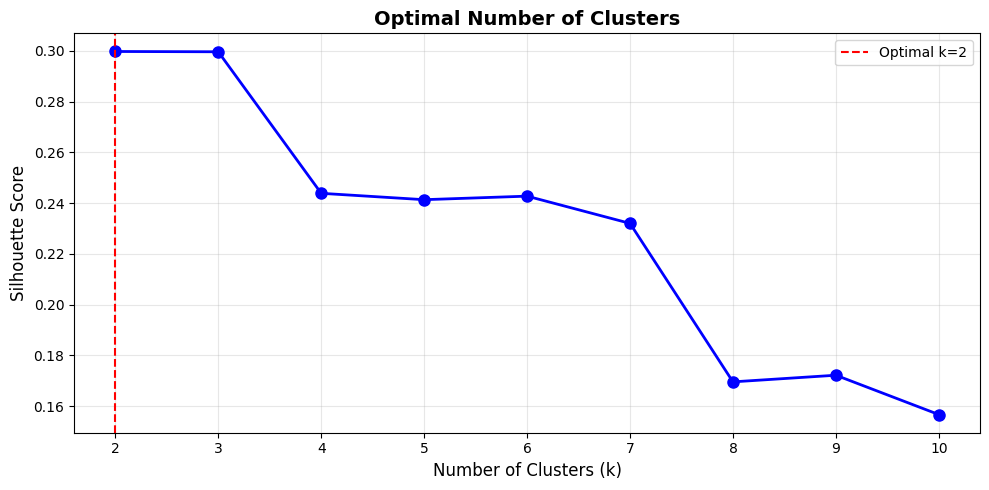

In [18]:
# feature selection and optional subset 

key_baseline_cols = []

edu_cols = [col for col in X_baseline.columns if 'edu' in col.lower()]
key_baseline_cols.extend(edu_cols[:3])  # Top 3 education features
job_cols = [col for col in X_baseline.columns if 'job' in col.lower() or 'experience' in col.lower()]
key_baseline_cols.extend(job_cols[:3])  # Top 3 job features
industry_cols = [col for col in X_baseline.columns if 'industry' in col.lower()]
key_baseline_cols.extend(industry_cols[:2])  # Top 2 industry features

if len(key_baseline_cols) == 0:
    numeric_cols = X_baseline.select_dtypes(include=[np.number]).columns
    key_baseline_cols = list(numeric_cols[:10])

key_baseline_cols = [col for col in key_baseline_cols if col in X_baseline.columns]
key_baseline_cols = list(set(key_baseline_cols))

print(f"Selected {len(key_baseline_cols)} baseline features for clustering:")
for col in key_baseline_cols:
    print(f"  - {col}")

X_baseline_clustering = X_baseline[key_baseline_cols].fillna(0)
X_baseline_clustering_all = X_baseline.fillna(0)

# standardisation

scaler = StandardScaler()
baseline_scaled = scaler.fit_transform(X_baseline_clustering)
baseline_scaled_all = scaler.fit_transform(X_baseline_clustering_all)
embeddings_scaled = scaler.fit_transform(gnn_embeddings)

# concatenate 

combined_features = np.concatenate([
    embeddings_scaled,
    baseline_scaled_all
], axis=1)

# sillhouette score - cluster optisimation (optional)

k_range = range(2, 11)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(combined_features)
    score = silhouette_score(combined_features, cluster_labels)
    silhouette_scores.append(score)
    print(f"  k={k}: silhouette score = {score:.4f}")

optimal_k = k_range[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(list(k_range), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Optimal Number of Clusters', fontsize=14, fontweight='bold')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()


### Cluster Archetype Analysis

**For each cluster, compute:**

1. **Basic Stats**
   - Size (number of founders)
   - Success rate (% who succeeded)
   - Average GNN score

2. **Distinguishing Features**
   - Compare cluster's average features to overall average
   - Show top 15 most different features
   - ↑ = cluster has MORE, ↓ = cluster has LESS
   - Ratio shows how much more/less (2x = twice as much)

3. **Human-Readable Description**
   - Success level: High (>15%), Medium (8-15%), Low (<8%)
   - Network strength: Strong (>1.2x avg), Weak (<0.8x avg)
   - Key characteristics: Elite Education, Experienced, Tech Background, etc.
   - Generated from top distinguishing features

**Example:**

Cluster 2: High Success | Strong Network | Elite Education | Experienced
- 900 founders (11.1%)
- Success Rate: 23.5%
- Top features: 12.5 years experience, PhD degree, CXO roles

**Interpretation:**
Each cluster represents a distinct "archetype" of founders with similar backgrounds and success patterns.

In [19]:
# clustering using chosen cluster amount

optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(combined_features)
for c in range(optimal_k):
    n_in_cluster = (clusters == c).sum()
    pct = n_in_cluster / N_FOUNDERS * 100
    print(f"  Cluster {c}: {n_in_cluster:4d} founders ({pct:5.1f}%)")

# cluster analysis

cluster_descriptions = {}
cluster_stats = {}
for c in range(optimal_k):
    cluster_mask = (clusters == c)
    n_in_cluster = cluster_mask.sum()
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {c}")
    print(f"{'='*80}")
    
    # stats
    success_rate = y[cluster_mask].mean()
    avg_gnn_score = gnn_predictions[cluster_mask].mean()
    
    print(f"Size: {n_in_cluster} founders ({n_in_cluster/N_FOUNDERS*100:.1f}%)")
    print(f"Success Rate: {success_rate:.1%}")
    print(f"Avg GNN Score: {avg_gnn_score:.1%}")
    
    # avg baseline and distinguishing features
    cluster_baseline = X_baseline_clustering_all[cluster_mask].mean()
    overall_mean = X_baseline_clustering_all.mean()
    deviations = abs(cluster_baseline - overall_mean)
    top_features = deviations.nlargest(15)
    print(f"\nDistinguishing Features:")
    for feat in top_features.index:
        cluster_val = cluster_baseline[feat]
        overall_val = overall_mean[feat]
        ratio = cluster_val / (overall_val + 1e-10)
        direction = "↑" if cluster_val > overall_val else "↓"
        print(f"  {direction} {feat:40s}: {cluster_val:6.2f} (avg: {overall_val:6.2f}, {ratio:.2f}x)")
    
    # description
    description_parts = []
    if success_rate > 0.15:
        description_parts.append("High Success")
    elif success_rate > 0.08:
        description_parts.append("Medium Success")
    else:
        description_parts.append("Low Success")
    if avg_gnn_score > gnn_predictions.mean() * 1.2:
        description_parts.append("Strong Network")
    elif avg_gnn_score < gnn_predictions.mean() * 0.8:
        description_parts.append("Weak Network")
    for feat in top_features.index[:3]:
        cluster_val = cluster_baseline[feat]
        overall_val = overall_mean[feat]
        
        if cluster_val > overall_val * 1.3:
            if 'edu' in feat.lower() and 'top' in feat.lower():
                description_parts.append("Elite Education")
            elif 'senior' in feat.lower() or 'leadership' in feat.lower():
                description_parts.append("Senior Leadership")
            elif 'experience' in feat.lower() or 'years' in feat.lower():
                description_parts.append("Experienced")
            elif 'tech' in feat.lower():
                description_parts.append("Tech Background")
        elif cluster_val < overall_val * 0.7:
            if 'experience' in feat.lower() or 'years' in feat.lower():
                description_parts.append("Early Career")
    description = " | ".join(description_parts) if description_parts else f"Cluster {c}"
    cluster_descriptions[c] = description
    
    cluster_stats[c] = {
        'size': int(n_in_cluster),
        'success_rate': float(success_rate),
        'avg_gnn_score': float(avg_gnn_score),
        'description': description
    }
    
    print(f"\n✓ Cluster Label: {description}")


  Cluster 0: 1381 founders ( 17.0%)
  Cluster 1: 4341 founders ( 53.6%)
  Cluster 2: 1406 founders ( 17.4%)
  Cluster 3:  972 founders ( 12.0%)

CLUSTER 0
Size: 1381 founders (17.0%)
Success Rate: 5.7%
Avg GNN Score: 0.7%

Distinguishing Features:
  ↓ edu_num_degrees                         :   0.58 (avg:   1.39, 0.42x)
  ↓ edu_highest_degree_score                :   0.36 (avg:   1.04, 0.35x)
  ↓ job_num_senior_roles                    :   1.88 (avg:   2.44, 0.77x)
  ↓ job_big_company_then_startup            :   0.07 (avg:   0.36, 0.20x)
  ↓ job_num_business_roles                  :   0.21 (avg:   0.45, 0.47x)
  ↓ edu_is_stem                             :   0.15 (avg:   0.38, 0.38x)
  ↓ job_num_product_roles                   :   0.18 (avg:   0.37, 0.49x)
  ↓ edu_is_top50_school                     :   0.08 (avg:   0.25, 0.33x)
  ↓ edu_is_business                         :   0.13 (avg:   0.29, 0.43x)
  ↓ edu_has_mba                             :   0.04 (avg:   0.15, 0.29x)
  ↓ edu_is_t

### Visualisation

**PCA Dimensionality Reduction**
- Reduces 303-dim feature space to 2-dim for visualization
- PC1 and PC2 capture most variance (typically 40-50% total)
- Remaining dimensions lost but OK for visualization

**Left Plot: Founder Archetypes**
- Each color = one cluster
- Position shows similarity (close = similar profiles)
- Tight groups = well-defined archetypes
- Separation = distinct founder types

**Right Plot: Success Patterns**
- Color shows actual success (green = success, red = failure)
- Reveals which regions of feature space predict success
- If green aligns with a cluster → that cluster is high-performing

**Interpretation:**
Successful founders (green) should cluster together in certain regions, validating that the GNN learned meaningful patterns.

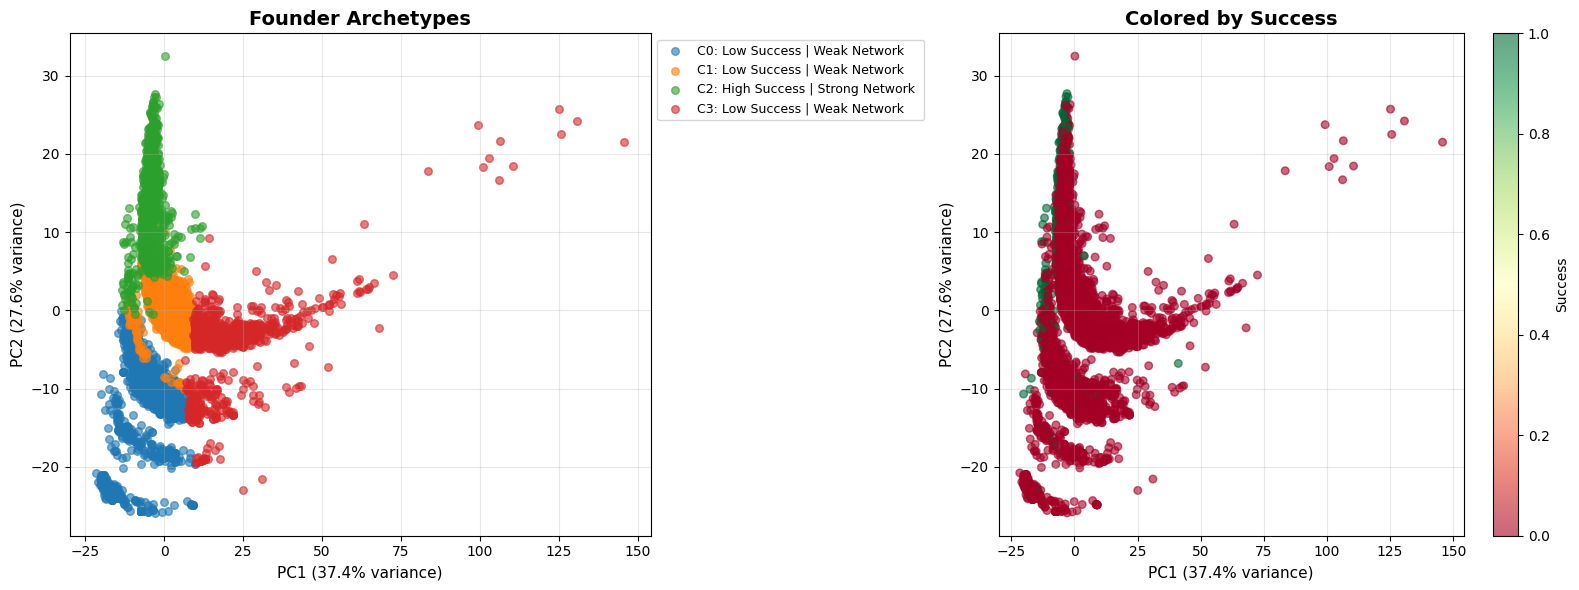

"\n# cluster assignments save\ncluster_df = pd.DataFrame({\n    'founder_idx': range(N_FOUNDERS),\n    'cluster': clusters,\n    'cluster_description': [cluster_descriptions[c] for c in clusters],\n    'gnn_prediction': gnn_predictions,\n    'success': y\n})\n\ncluster_df.to_csv('founder_cluster_assignments.csv', index=False)\nwith open('cluster_statistics.json', 'w') as f:\n    json.dump(cluster_stats, f, indent=2)\n"

In [ ]:
# visualisation

pca = PCA(n_components=2)
combined_pca = pca.fit_transform(combined_features)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# clusters
ax = axes[0]
for c in range(optimal_k):
    cluster_mask = (clusters == c)
    ax.scatter(combined_pca[cluster_mask, 0], combined_pca[cluster_mask, 1],
               label=f"C{c}: {cluster_descriptions[c][:30]}",
               alpha=0.6, s=30)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title('Founder Archetypes', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
ax.grid(True, alpha=0.3)

# colour by success
ax = axes[1]
scatter = ax.scatter(combined_pca[:, 0], combined_pca[:, 1],
                     c=y, cmap='RdYlGn', alpha=0.6, s=30,
                     vmin=0, vmax=1)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax.set_title('Colored by Success', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Success')

plt.tight_layout()
plt.show()
plt.close()

'''
# cluster assignments save
cluster_df = pd.DataFrame({
    'founder_idx': range(N_FOUNDERS),
    'cluster': clusters,
    'cluster_description': [cluster_descriptions[c] for c in clusters],
    'gnn_prediction': gnn_predictions,
    'success': y
})

cluster_df.to_csv('founder_cluster_assignments.csv', index=False)
with open('cluster_statistics.json', 'w') as f:
    json.dump(cluster_stats, f, indent=2)
'''

# Assigning Unseen Founders

In this code we are not retraining: we are testing whether the clustering model learned on the training data generalises to the unseen test data.

Data Splitting
- the data was previosly split using masks
- the test set was held out

For both we use both GNN embeddings and all baseline features

Training phase
- This is not the GNN being re-trained as embeddinsg are pre-computed and loaded from the files
- Standard scalers are Kmeans are freshly trained in this section on train+val (we refit the scaling and clustering as shown above) - new instance of everything
    - we used the same random_state of 42 here so the re-fitted kmeans will produce identical cluster centroids
    - this code creates new kmeans and scalar instance which are fitted on the train+val data
    - the train+val embeddings use labels for fitting scalars and kemeans
    - Method
    1) Combines GNN embeddings and baseline features
    2) Finds natural groupings (clusters) in the combined space
    3) Labels new founders based on which centroid closest too

```
                    ┌──────────────────────┐
                    │   GNN (pre-trained)  │
                    │   on train+val labels│
                    └──────────┬───────────┘
                               │
                               ▼
                    Embeddings for ALL founders
                               │
         ┌─────────────────────┴─────────────────────┐
         ▼                                           ▼
   Train+Val embeddings                        Test embeddings
         +                                           +
   Train+Val baseline                          Test baseline
         │                                           │
         ▼                                           ▼
   fit() scalers                              transform() only
   fit() KMeans                               predict() only
         │                                           │
         ▼                                           ▼
   Cluster assignments                        Cluster assignments
   + compute success rates                    + compute success rates
   (using train+val labels)                   (using test labels)
         │                                           │
         └──────────────► COMPARE ◄──────────────────┘
                    "Do patterns hold?"
```

Testing phase - 'if i fit clusters on train_val and call cluster 2 high success do new founders assigned to cluster 2 also have high success?'
- There are embeddings for *everyone* because the GNN seeds all nodes during message passing
- On the test data, we do not do only fitting
- We only transform using training statistics
- **.transform() and .preidict() dont learn anything new** -> they apply already-learned parameters to the new data (NOT FIT)
    - transform: applies already stored mean/std
    - predict: for each point, it iteratively finds which stored centroid is closest
- test validates whether cluster patterns hold for unseen founders

```
┌─────────────────────────────────────────────────────────────────┐
│                         TRAINING                                │
├─────────────────────────────────────────────────────────────────┤
│  Scaler.fit(train)     →  Learns: mean=30, std=14.14           │
│  Scaler.transform(train) →  Outputs: normalized train data      │
│                                                                 │
│  KMeans.fit(train)     →  Learns: centroid positions           │
│  KMeans.predict(train) →  Outputs: cluster labels (0,1,2,3)    │
└─────────────────────────────────────────────────────────────────┘
                              ↓
                    Parameters are FROZEN
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│                         TESTING                                 │
├─────────────────────────────────────────────────────────────────┤
│  Scaler.transform(test)  →  Uses SAME mean/std from training   │
│  KMeans.predict(test)    →  Assigns to SAME centroids          │
│                                                                 │
│  NO NEW LEARNING - just applying stored parameters             │
└─────────────────────────────────────────────────────────────────┘
```


### Data Loading

In [21]:
# config 

NUM_CLUSTERS = 4 

# data

X_baseline_full = pd.read_csv(RAW_DIR / 'baseline_features.csv')
gnn_embeddings_full = np.load(GNN_DIR / 'embeddings.npy')
gnn_predictions_full = np.load(GNN_DIR / 'predictions.npy')
y_full = pd.read_csv(RAW_DIR / 'labels.csv')['success'].values

# mask

masks = np.load(RAW_DIR / 'masks.npz')
test_mask = masks['test_mask']
train_val_mask = (masks['train_mask'] | masks['val_mask'])
X_baseline_train = X_baseline_full[train_val_mask].reset_index(drop=True)
gnn_embeddings_train = gnn_embeddings_full[train_val_mask]
gnn_predictions_train = gnn_predictions_full[train_val_mask]
y_train = y_full[train_val_mask]

X_baseline_test = X_baseline_full[test_mask].reset_index(drop=True)
gnn_embeddings_test = gnn_embeddings_full[test_mask]
gnn_predictions_test = gnn_predictions_full[test_mask]
y_test = y_full[test_mask]


### Cluster 

In [22]:
# scale

scaler_baseline = StandardScaler()
scaler_embeddings = StandardScaler()
baseline_train_scaled = scaler_baseline.fit_transform(X_baseline_train.fillna(0))
embeddings_train_scaled = scaler_embeddings.fit_transform(gnn_embeddings_train)
combined_train = np.concatenate([embeddings_train_scaled, baseline_train_scaled], axis=1)

# cluster 
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters_train = kmeans_final.fit_predict(combined_train)

# analyse and sort clusters by success
cluster_success_rates = []
for c in range(optimal_k):
    mask = (clusters_train == c)
    size = mask.sum()
    success_rate = y_train[mask].mean()
    cluster_success_rates.append((c, success_rate))
    print(f"  Cluster {c}: {size:4d} founders ({size/len(y_train)*100:5.1f}%), " +
          f"success rate: {success_rate:.1%}")
cluster_success_rates.sort(key=lambda x: x[1], reverse=True)
print(f"\nClusters ranked by success rate:")
for i, (c, rate) in enumerate(cluster_success_rates):
    if i == 0:
        status = "HIGH"
    elif i < optimal_k // 2:
        status = "MED-HIGH"
    elif i < (optimal_k * 2) // 3:
        status = "MED"
    else:
        status = "LOW"
    print(f"  {status}: Cluster {c} ({rate:.1%})")

  Cluster 0: 1381 founders ( 17.0%), success rate: 5.7%
  Cluster 1: 4341 founders ( 53.6%), success rate: 7.0%
  Cluster 2: 1406 founders ( 17.4%), success rate: 23.5%
  Cluster 3:  972 founders ( 12.0%), success rate: 1.6%

Clusters ranked by success rate:
  HIGH: Cluster 2 (23.5%)
  MED-HIGH: Cluster 1 (7.0%)
  LOW: Cluster 0 (5.7%)
  LOW: Cluster 3 (1.6%)


### Test

**Goal:** Validate that clusters generalize to unseen founders

**Process:**
1. **Scale test data** using training scaler (no fitting on test!)
2. **Assign test founders** to clusters using trained KMeans (no fitting!)
3. **Compare performance** between train and test per cluster

**Metrics:**
- **Train vs Test success rates**: Should be similar (validates generalization)
- **Distribution of successful test founders**: Should concentrate in high-success clusters

**Example:**
Cluster 2 (HIGH SUCCESS): Train: 23.5% success (900 founders) Test: 22.1% success (110 founders) ← Similar! Generalizes well Contains: 44% of all successful test founders ← Most successful test founders here!


**Interpretation:**
If train and test success rates align, and successful test founders concentrate in high-success clusters, the clustering is predictive and generalizes.

Key Difference: Training fits the scaler and kmeans; testing only transforms/predicts using the already-fitted models. This prevents data leakage.

In [ ]:
# scale

baseline_test_scaled = scaler_baseline.transform(X_baseline_test.fillna(0))
embeddings_test_scaled = scaler_embeddings.transform(gnn_embeddings_test)
combined_test = np.concatenate([embeddings_test_scaled, baseline_test_scaled], axis=1)

# assign
clusters_test = kmeans_final.predict(combined_test)

# evaluate
for c in range(optimal_k):
    train_mask_c = (clusters_train == c)
    test_mask_c = (clusters_test == c)
    
    train_size = train_mask_c.sum()
    test_size = test_mask_c.sum()
    
    train_success = y_train[train_mask_c].mean() if train_size > 0 else 0
    test_success = y_test[test_mask_c].mean() if test_size > 0 else 0
    
    print(f"{c:<10} {train_size:<18} {test_size:<15} {train_success:<18.1%} {test_success:<18.1%}")

# analysis of success

successful_test = (y_test == 1)
n_successful = successful_test.sum()

for c in range(optimal_k):
    mask = (clusters_test == c) & successful_test
    count = mask.sum()
    pct = count / n_successful * 100 if n_successful > 0 else 0
    
    # Find cluster rank
    cluster_rank = next(i for i, (cluster_id, _) in enumerate(cluster_success_rates) if cluster_id == c)
    
    if cluster_rank == 0:
        status = "HIGH SUCCESS CLUSTER"
    elif cluster_rank < optimal_k // 2:
        status = "MED-HIGH SUCCESS CLUSTER"
    elif cluster_rank < (optimal_k * 2) // 3:
        status = "MED SUCCESS CLUSTER"
    else:
        status = "LOW SUCCESS CLUSTER"
    
    print(f"  Cluster {c} ({status}): {count:3d} successful founders ({pct:5.1f}%)")

0          1381               162             5.7%               7.4%              
1          4341               475             7.0%               7.4%              
2          1406               140             23.5%              22.1%             
3          972                123             1.6%               2.4%              
  Cluster 0 (LOW SUCCESS CLUSTER):  12 successful founders ( 14.8%)
  Cluster 1 (MED-HIGH SUCCESS CLUSTER):  35 successful founders ( 43.2%)
  Cluster 2 (HIGH SUCCESS CLUSTER):  31 successful founders ( 38.3%)
  Cluster 3 (LOW SUCCESS CLUSTER):   3 successful founders (  3.7%)


### Visualise

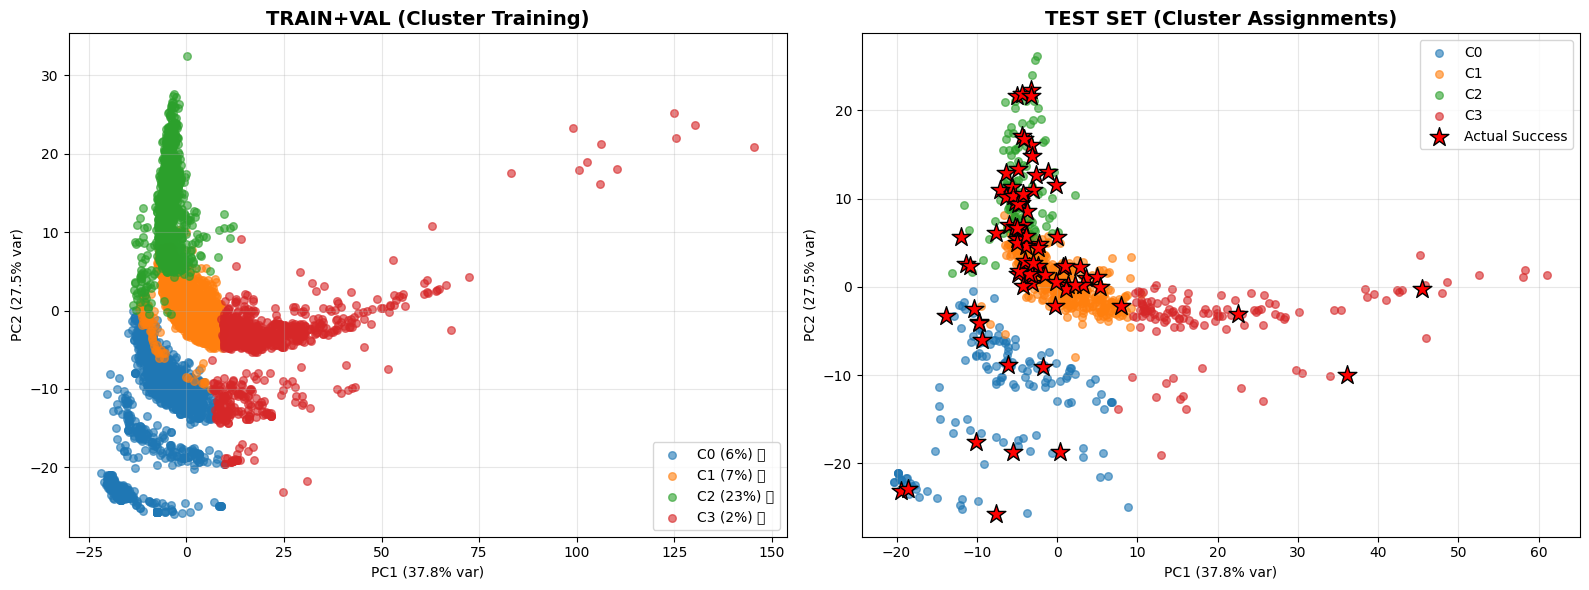

In [ ]:
# two dimensions
pca = PCA(n_components=2)
combined_all = np.concatenate([combined_train, combined_test], axis=0)
combined_pca = pca.fit_transform(combined_all)

n_train = len(combined_train)
train_pca = combined_pca[:n_train]
test_pca = combined_pca[n_train:]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# train clusters
ax = axes[0]
for c in range(optimal_k):
    mask = (clusters_train == c)
    success_rate = y_train[mask].mean()
    cluster_rank = next(i for i, (cluster_id, _) in enumerate(cluster_success_rates) if cluster_id == c)
    
    if cluster_rank == 0:
        emoji = "🟢"
    elif cluster_rank < optimal_k // 2:
        emoji = "🟡"
    else:
        emoji = "🔴"
    
    label = f"C{c} ({success_rate:.0%}) {emoji}"
    ax.scatter(train_pca[mask, 0], train_pca[mask, 1], label=label, alpha=0.6, s=30)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('TRAIN+VAL (Cluster Training)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# test assignments and highlight
ax = axes[1]
for c in range(optimal_k):
    mask = (clusters_test == c)
    ax.scatter(test_pca[mask, 0], test_pca[mask, 1], label=f"C{c}", alpha=0.6, s=30)
successful_mask = (y_test == 1)
ax.scatter(test_pca[successful_mask, 0], test_pca[successful_mask, 1],
           marker='*', s=200, c='red', edgecolors='black', linewidths=1,
           label='Actual Success', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('TEST SET (Cluster Assignments)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Investment Strategy - top n clusters

This code just creates a mock investment strategy too see how many too chose

In [ ]:
# top 1 cluster
high_success_cluster = cluster_success_rates[0][0]
in_top1 = (clusters_test == high_success_cluster)

if in_top1.sum() > 0:
    precision_top1 = y_test[in_top1].mean()
    coverage_top1 = in_top1.sum() / len(y_test)
    captured_top1 = (y_test[in_top1] == 1).sum()
    
    print(f"\nStrategy 1: TOP 1 cluster (Cluster {high_success_cluster}):")
    print(f"  Founders selected: {in_top1.sum()}")
    print(f"  Precision: {precision_top1:.1%}")
    print(f"  Coverage: {coverage_top1:.1%}")
    print(f"  Lift: {precision_top1 / y_test.mean():.2f}x vs base rate ({y_test.mean():.1%})")
    print(f"  Captured: {captured_top1}/{n_successful} successful founders ({captured_top1/n_successful*100:.1f}%)")

# top 2 clusters
if optimal_k >= 2:
    top2_clusters = [cluster_success_rates[i][0] for i in range(2)]
    in_top2 = np.isin(clusters_test, top2_clusters)
    
    if in_top2.sum() > 0:
        precision_top2 = y_test[in_top2].mean()
        coverage_top2 = in_top2.sum() / len(y_test)
        captured_top2 = (y_test[in_top2] == 1).sum()
        
        print(f"\nStrategy 2: TOP 2 clusters (Clusters {top2_clusters}):")
        print(f"  Founders selected: {in_top2.sum()}")
        print(f"  Precision: {precision_top2:.1%}")
        print(f"  Coverage: {coverage_top2:.1%}")
        print(f"  Lift: {precision_top2 / y_test.mean():.2f}x vs base rate")
        print(f"  Captured: {captured_top2}/{n_successful} successful founders ({captured_top2/n_successful*100:.1f}%)")

# top 3 clusters
if optimal_k >= 3:
    top3_clusters = [cluster_success_rates[i][0] for i in range(3)]
    in_top3 = np.isin(clusters_test, top3_clusters)
    
    if in_top3.sum() > 0:
        precision_top3 = y_test[in_top3].mean()
        coverage_top3 = in_top3.sum() / len(y_test)
        captured_top3 = (y_test[in_top3] == 1).sum()
        
        print(f"\nStrategy 3: TOP 3 clusters (Clusters {top3_clusters}):")
        print(f"  Founders selected: {in_top3.sum()}")
        print(f"  Precision: {precision_top3:.1%}")
        print(f"  Coverage: {coverage_top3:.1%}")
        print(f"  Lift: {precision_top3 / y_test.mean():.2f}x vs base rate")
        print(f"  Captured: {captured_top3}/{n_successful} successful founders ({captured_top3/n_successful*100:.1f}%)")


Strategy 1: TOP 1 cluster (Cluster 2):
  Founders selected: 140
  Precision: 22.1%
  Coverage: 15.6%
  Lift: 2.46x vs base rate (9.0%)
  Captured: 31/81 successful founders (38.3%)

Strategy 2: TOP 2 clusters (Clusters [2, 1]):
  Founders selected: 615
  Precision: 10.7%
  Coverage: 68.3%
  Lift: 1.19x vs base rate
  Captured: 66/81 successful founders (81.5%)

Strategy 3: TOP 3 clusters (Clusters [2, 1, 0]):
  Founders selected: 777
  Precision: 10.0%
  Coverage: 86.3%
  Lift: 1.12x vs base rate
  Captured: 78/81 successful founders (96.3%)
